## Pengembangan Fitur Keterbacaan Teks Bahasa Indonesia melalui Kombinasi Kajian Linguistik dengan Pendekatan Natural Language Processing

- Status proyek : RAHASIA NEGARA (DALAM STATUS RISET)
- Bagian ini merupakan split dari Notebook sebelumnya untuk memperingan proses training model parafrasa kadal berotot mark 1

## Prep Pairs untuk skoring awal menggunakan T5

Kode ini melatih dan menguji sistem parafrasa otomatis Bahasa Indonesia skala besar, menggunakan kombinasi model generatif (IndoT5) dan model penilai keterbacaan berbasis ML (joblib) untuk memilih hasil terbaik.

Pipeline ini melakukan paraphrasing → scoring → seleksi berbasis gain metrik linguistik. 

Tujuannya: menghasilkan kalimat baru yang lebih mudah dibaca, tetap ilmiah, dan mempertahankan istilah penting.

### Dasar Teori Tiap Komponen



1. Model Generatif – IndoT5
    Teori: IndoT5 adalah model sequence-to-sequence transformer (berbasis encoder–decoder, seperti T5), dilatih untuk tugas teks-ke-teks.
    Fungsi di sini: menghasilkan beberapa candidate paraphrase dari satu kalimat asli.

    Teknik:
    - Beam search untuk hasil deterministik (top-N kandidat terbaik)
    - Sampling (top-k, top-p) untuk variasi tambahan
    - Pemblokiran token sentinel <extra_id_x> agar hasil bersih

2. Constraint Paraphrase Prompt

    Prompt berformat:

    <paraphrase: {kalimat_asli} ||| Constraints: satu kalimat Indonesia ...>

    Memberi instruksi agar output ringkas, aktif, tetap ilmiah, dan menjaga istilah teknis (hasil extract_terms).
    Teori: teknik prompt conditioning – mempengaruhi keluaran model dengan perintah tekstual.


3. Model Penilai Kualitas (Scoring Models)
    Disimpan dalam file model_*.joblib dan meta.joblib. Berbasis model pembelajaran mesin klasik (mis. RandomForest, XGBoost), yang diberi input fitur linguistik.

    Fitur utama:
    - IndoBERT embedding → representasi semantik kalimat.
    - Contextual similarity features → kemiripan antar kalimat tetangga (koherensi konteks).
    - POS features (opsional) → proporsi kelas kata (keteraturan sintaksis).

    Memprediksi skor seperti:
    - Flesch_Normalized → keterbacaan (semakin tinggi = makin mudah dibaca)
    - Narrativity → seberapa naratif
    - Syntactic_Simplicity → kesederhanaan struktur
    - Cohesion → keterkaitan ide antar kalimat


4. multi-objective optimization—pilih solusi dengan peningkatan signifikan minimal di satu dimensi kualitas.
    Proses “Gain Selection” nya
    - Untuk setiap kalimat asli → hasilkan N kandidat parafrasa.
    - Tiap kandidat dinilai ulang menggunakan model score_with_models.
    - Diterima hanya jika ada satu metrik yang naik ≥ min_gain_any.
    
5. Feature Engineering & Embedding
    Teorinya berakar pada representasi distribusional bahasa: kalimat mirip makna → vektor berdekatan di ruang embedding.
    embed_indobert(): menghasilkan representasi vektor semantik.
    build_context_features(): menghitung cosine similarity antar tetangga (pakai SentenceTransformer multilingual MiniLM).
    build_pos_features(): distribusi kelas kata POS (dari Stanza).

6. Evaluasi & Iteratif Paraphrasing
    Pipeline diatur per shard (batch ribuan kalimat) → efisien untuk dataset besar.

    Output:
    - *_all.csv: semua kandidat + skor
    - *_accepted.csv: hanya kandidat yang lolos kriteria
    - JSON index untuk resume (checkpoint)
    

### Kode training

In [24]:
# -*- coding: utf-8 -*-
"""
Paraphrase skala besar (longgar + multi-candidate):
- Model: Wikidepia/IndoT5-base-paraphrase
- Tiap kalimat hasilkan N kandidat; pilih yang memberi gain terbaik
- Accept jika ADA satu indikator (konfigurabel) naik >= min_gain_any
- Blokir <extra_id_*>, sanitize, fallback sampling
- Skor pakai model keterbacaan (meta.joblib + model_*.joblib)
"""

import os, re, argparse, json, unicodedata, warnings
from typing import List, Dict, Tuple
import numpy as np, pandas as pd, torch, joblib
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoTokenizer as _Tok, AutoModel as _Bert
from sentence_transformers import SentenceTransformer

# ---------------- Defaults ----------------
DEFAULT_T5 = "Wikidepia/IndoT5-base-paraphrase"
MAX_NEW_TOKENS = 96
NUM_BEAMS = 4
NO_REPEAT_NGRAM = 3
BATCH_GEN = 12

ID_STOP = set("yang dan di ke dari untuk pada dengan kepada sebagai adalah ialah yakni yaitu atau namun tetapi karena sehingga maka agar supaya sebuah para itu ini pun jika bila apabila saat ketika sementara selama hingga kemudian telah sudah akan".split())
_token_pat = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿĀ-žΑ-ωА-я'’\-]+")
_tok_ctx   = re.compile(r"[a-zA-ZÀ-ÿ]+", re.UNICODE)

def norm_tokens(s: str):
    toks = [t.lower() for t in _tok_ctx.findall(str(s))]
    return [t for t in toks if t not in ID_STOP and not t.isnumeric() and len(t) > 2]

def jaccard(a, b):
    sa, sb = set(a), set(b)
    if not sa and not sb: return 0.0
    return len(sa & sb) / max(1, len(sa | sb))

def extract_terms(text: str, topk: int = 5) -> List[str]:
    toks = _token_pat.findall(str(text))
    cand = []
    for t in toks:
        tl = t.strip("’'-").strip()
        if len(tl) >= 8 or "-" in tl or re.match(r"^[A-Z][a-zA-Z\-]+$", t):
            cand.append(tl)
    cand = list(dict.fromkeys(cand))
    cand = sorted(cand, key=lambda x: (-len(x), x.lower()))
    return [c for c in cand[:max(1, topk)]]

def build_prompt(src, keep_terms):
    kt = ", ".join(keep_terms) if keep_terms else ""
    # IndoT5: prefix "paraphrase:" + constraint ringan
    return (
        f"paraphrase: {src} ||| "
        f"Constraints: satu kalimat Indonesia yang ringkas, aktif, sedikit lebih naratif, tetap ilmiah. "
        f"Pertahankan istilah teknis bila relevan: [{kt}]"
    )

# --- sentinel blocker & cleaners ---
def sentinel_bad_word_ids(tok):
    bad = []
    vocab = tok.get_vocab()
    for i in range(200):  # jaga-jaga hingga 200
        t = f"<extra_id_{i}>"
        if t in vocab:
            bad.append([tok.convert_tokens_to_ids(t)])
    for t in ["<unk>", "<mask>"]:
        if t in vocab:
            bad.append([tok.convert_tokens_to_ids(t)])
    return bad

_LATIN_LINE_RE = re.compile(r"^[\s\w\-\.,;:'\"()\[\]/%±‘’“”–—…!?]+$", re.UNICODE)

def clean_text_simple(s: str) -> str:
    s = s.replace("\u200b", " ").replace("\ufeff", " ")
    s = re.sub(r"<extra_id_\d+>", "", s)  # buang sentinel yg lolos
    s = re.sub(r"\s+", " ", s).strip()
    return s

def looks_ok_id(s: str) -> bool:
    s_norm = unicodedata.normalize("NFKC", s)
    if not _LATIN_LINE_RE.match(s_norm):
        letters = sum(ch.isalpha() for ch in s_norm)
        # kasar: jika banyak huruf non-latin → tolak
        bad = sum(ch.isalpha() and not ('\u0000' <= ch <= '\u024F') for ch in s_norm)
        if letters > 0 and (bad / letters) > 0.05:
            return False
    if len(s_norm) < 12 or not re.search(r"[aiueoAIUEO]", s_norm):
        return False
    if re.search(r"<extra_id_\d+>", s_norm):
        return False
    return True

# ---------- IndoBERT embed + context ----------
def mean_pooling(h, mask):
    mask = mask.unsqueeze(-1).expand(h.size()).float()
    return (h*mask).sum(1) / mask.sum(1).clamp(min=1e-9)

@torch.no_grad()
def embed_indobert(texts: List[str], hf_model: str, device: str = "cuda", max_len: int = 128, bs: int = 128):
    tok = _Tok.from_pretrained(hf_model)
    bert = _Bert.from_pretrained(hf_model).to(device).eval()
    try:
        if device == "cuda":
            bert = bert.half()
    except Exception:
        pass
    outs=[]
    for i in range(0, len(texts), bs):
        batch = texts[i:i+bs]
        enc = tok(batch, return_tensors="pt", truncation=True, padding=True, max_length=max_len).to(device)
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda")):
            h = bert(**enc).last_hidden_state
        pooled = mean_pooling(h, enc["attention_mask"]).cpu().numpy()
        outs.append(pooled)
    return np.vstack(outs)

def build_context_features(texts: List[str]) -> np.ndarray:
    sbert = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
    embs = sbert.encode(texts, batch_size=512, convert_to_numpy=True, normalize_embeddings=True)
    N = len(texts)
    sim_prev = np.zeros(N); sim_next = np.zeros(N)
    overlap_prev = np.zeros(N); overlap_next = np.zeros(N)
    toks = [norm_tokens(t) for t in texts]
    for i in range(N):
        if i-1 >= 0:
            sim_prev[i] = float(np.dot(embs[i], embs[i-1]))
            overlap_prev[i] = jaccard(toks[i], toks[i-1])
        if i+1 < N:
            sim_next[i] = float(np.dot(embs[i], embs[i+1]))
            overlap_next[i] = jaccard(toks[i], toks[i+1])
    return np.column_stack([sim_prev, sim_next, overlap_prev, overlap_next])

# ---------- POS optional (lambat) ----------
def build_pos_features(texts: List[str], pos_tags: List[str], enable: bool) -> np.ndarray:
    if not enable or not pos_tags:
        return np.zeros((len(texts), len(pos_tags or [])), dtype=np.float32)
    import stanza
    stanza.download('id', processors='tokenize,pos', verbose=False)
    nlp = stanza.Pipeline(lang='id', processors='tokenize,pos',
                          use_gpu=torch.cuda.is_available(), tokenize_no_ssplit=True, verbose=False)
    feats = np.zeros((len(texts), len(pos_tags)), dtype=np.float32)
    tag_index = {t:i for i,t in enumerate(pos_tags)}
    for i, txt in enumerate(texts):
        try:
            doc = nlp(txt if isinstance(txt, str) else str(txt))
            total = 0
            counts = np.zeros(len(pos_tags), dtype=np.float32)
            for sent in doc.sentences:
                for w in sent.words:
                    total += 1
                    if w.upos in tag_index:
                        counts[tag_index[w.upos]] += 1
            feats[i,:] = counts / max(1, total)
        except Exception:
            feats[i,:] = 0.0
    return feats

def make_feature_matrix(texts: List[str], meta: dict, fast_mode: bool) -> np.ndarray:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    X_bert = embed_indobert(texts, meta["hf_model"], device=device, max_len=128, bs=128)
    X_ctx  = build_context_features(texts)
    X_pos  = build_pos_features(texts, meta.get("pos_tags", []), enable=(meta.get("use_pos_features", False) and not fast_mode))
    return np.hstack([X_bert, X_ctx, X_pos])

def score_with_models(texts: List[str], meta: dict, targets: List[str], models: Dict[str, object], fast_mode: bool) -> pd.DataFrame:
    X = make_feature_matrix(texts, meta, fast_mode=fast_mode)
    out = {}
    for t in targets:
        out[t] = models[t].predict(X)
    return pd.DataFrame(out)

# ---------- istilah checker ----------
def keep_ok(paraf: str, terms: List[str]) -> bool:
    if not terms:
        return True
    p = re.sub(r"[^\w\s\-]", " ", paraf.lower())
    bag = set(p.split())
    for term in terms:
        t = term.strip().lower()
        if not t:
            continue
        toks = [x for x in re.split(r"[\s\-]+", t) if x]
        if not toks:
            continue
        if not any(tok in bag for tok in toks[:2]):
            return False
    return True

# ---------- Paraphrase n-best ----------
def paraphrase_nbest(texts: List[str],
                     keep_terms_list: List[List[str]],
                     tok, t5, device,
                     bad_words_ids,
                     num_candidates: int) -> List[List[str]]:
    """
    Return: list of list candidates (len = len(texts)), each inner list up to num_candidates strings.
    Strategy:
      - Beam (ret_beam=min(num_candidates, NUM_BEAMS)) + blokir sentinel
      - Tambah sampling hingga num_candidates
      - Clean + basic quality check
    """
    prompts = [build_prompt(s, k) for s, k in zip(texts, keep_terms_list)]
    all_cands: List[List[str]] = [[] for _ in texts]

    for i in range(0, len(prompts), BATCH_GEN):
        chunk_idx = list(range(i, min(len(prompts), i+BATCH_GEN)))
        enc = tok(prompts[i:i+BATCH_GEN], return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)

        # Pass 1: beams
        ret_beam = min(num_candidates, NUM_BEAMS)
        gen = t5.generate(
            **enc,
            num_beams=max(NUM_BEAMS, ret_beam),
            num_return_sequences=ret_beam,
            do_sample=False,
            max_new_tokens=MAX_NEW_TOKENS,
            min_new_tokens=10,
            no_repeat_ngram_size=NO_REPEAT_NGRAM,
            repetition_penalty=1.12,
            bad_words_ids=bad_words_ids,
            length_penalty=1.0,
            early_stopping=True,
        )
        dec = tok.batch_decode(gen, skip_special_tokens=True)
        # reshape ke per-prompt
        for k, idx in enumerate(chunk_idx):
            cands = []
            for r in range(ret_beam):
                s = clean_text_simple(dec[(k*ret_beam)+r])
                if looks_ok_id(s):
                    cands.append(s)
            all_cands[idx].extend(cands)

        # Need more → sampling fill
        need_more_pairs: List[Tuple[int, str]] = []
        for idx in chunk_idx:
            cur = len(all_cands[idx])
            for _ in range(max(0, num_candidates - cur)):
                need_more_pairs.append((idx, prompts[idx]))
        if need_more_pairs:
            enc_fb = tok([p for (_, p) in need_more_pairs], return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
            gen_fb = t5.generate(
                **enc_fb,
                num_beams=1,
                do_sample=True,
                top_p=0.92,
                top_k=50,
                temperature=0.9,
                max_new_tokens=MAX_NEW_TOKENS,
                min_new_tokens=10,
                no_repeat_ngram_size=NO_REPEAT_NGRAM,
                bad_words_ids=bad_words_ids,
                early_stopping=True,
            )
            dec_fb = tok.batch_decode(gen_fb, skip_special_tokens=True)
            ptr = 0
            for idx, _ in need_more_pairs:
                s = clean_text_simple(dec_fb[ptr]); ptr += 1
                if looks_ok_id(s):
                    all_cands[idx].append(s)

        # fallback: jika tetap kosong, isi dgn kalimat asli
        for idx in chunk_idx:
            if not all_cands[idx]:
                all_cands[idx] = [texts[idx]]
            all_cands[idx] = all_cands[idx][:num_candidates]

    return all_cands

# ---------- Main ----------
def main():
    warnings.filterwarnings("ignore", category=UserWarning)
    from transformers.utils import logging as hf_logging
    hf_logging.set_verbosity_error()

    ap = argparse.ArgumentParser()
    ap.add_argument("--in", dest="inp", required=True)
    ap.add_argument("--out_dir", required=True)
    ap.add_argument("--model", default=DEFAULT_T5)
    ap.add_argument("--low_flesch", type=float, default=30.0)
    ap.add_argument("--limit", type=int, default=None)
    ap.add_argument("--shard_size", type=int, default=10000)
    ap.add_argument("--shard_idx", type=int, default=0)
    ap.add_argument("--fast_mode", action="store_true", help="Skip POS features for speed; POS only for final re-score if needed.")
    ap.add_argument("--save_every", type=int, default=1000)

    # aturan longgar
    ap.add_argument("--num_candidates", type=int, default=4, help="Jumlah kandidat per kalimat")
    ap.add_argument("--min_gain_any", type=float, default=2.0, help="Minimal kenaikan pada salah satu metrik untuk accept")
    ap.add_argument("--metrics_any", type=str, default="Flesch_Normalized,Narrativity,Syntactic_Simplicity,Referential_Cohesion,Deep_Cohesion",
                    help="Daftar metrik yang dihitung gain-nya, dipisah koma")

    args = ap.parse_args()
    metrics_any = [m.strip() for m in args.metrics_any.split(",") if m.strip()]

    os.makedirs(args.out_dir, exist_ok=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

    # Load data & select shard
    df = pd.read_csv(args.inp, encoding="utf-8-sig")
    if "Kalimat" not in df.columns:
        raise SystemExit("Kolom 'Kalimat' wajib ada.")
    if "Flesch_Normalized" in df.columns:
        df = df[df["Flesch_Normalized"].astype(float) < args.low_flesch]
    if args.limit:
        df = df.head(args.limit)
    N = len(df)
    start = args.shard_idx * args.shard_size
    end   = min(N, start + args.shard_size)
    if start >= N:
        print(f"[SKIP] shard_idx {args.shard_idx} di luar range. N={N}")
        return
    shard = df.iloc[start:end].reset_index(drop=True)
    print(f">> Device={device} | rows shard={len(shard)} [{start}:{end}) | fast_mode={args.fast_mode}")

    # Output paths
    base = os.path.join(args.out_dir, f"shard_{args.shard_idx:03d}")
    path_all = base + "_all.csv"
    path_acc = base + "_accepted.csv"
    path_done_idx = base + "_done.json"

    done_i = 0
    if os.path.exists(path_done_idx):
        try:
            done_i = int(json.loads(open(path_done_idx, "r", encoding="utf-8").read()).get("done", 0))
        except Exception:
            done_i = 0

    # Load scoring models
    meta = joblib.load("meta.joblib")
    targets = meta["targets"]
    models = {t: joblib.load(f"model_{t}.joblib") for t in targets}

    # Load T5
    try:
        tok = AutoTokenizer.from_pretrained(args.model, use_fast=False, legacy=False)
    except TypeError:
        # beberapa versi transformers tak punya arg legacy
        tok = AutoTokenizer.from_pretrained(args.model, use_fast=False)
    t5  = AutoModelForSeq2SeqLM.from_pretrained(args.model).to(device).eval()
    try:
        if device == "cuda":
            t5 = t5.half()
    except Exception:
        pass
    bad_words_ids = sentinel_bad_word_ids(tok)

    rows_all: List[Dict] = []
    rows_acc: List[Dict] = []

    def flush(cur_i: int):
        if rows_all:
            pd.DataFrame(rows_all).to_csv(path_all, index=False, encoding="utf-8")
        if rows_acc:
            pd.DataFrame(rows_acc).to_csv(path_acc, index=False, encoding="utf-8")
        with open(path_done_idx, "w", encoding="utf-8") as f:
            f.write(json.dumps({"done": cur_i}, ensure_ascii=False))
        print(f"[SAVE] upto i={cur_i} → {path_all} / {path_acc}")

    # Process per chunk
    cur_i = done_i
    while cur_i < len(shard):
        batch_end = min(len(shard), cur_i + args.save_every)
        batch_df = shard.iloc[cur_i:batch_end].copy()
        src_texts = batch_df["Kalimat"].astype(str).tolist()
        keep_terms_list = [extract_terms(t, topk=5) for t in src_texts]

        cands_list = paraphrase_nbest(
            src_texts, keep_terms_list,
            tok=tok, t5=t5, device=device,
            bad_words_ids=bad_words_ids,
            num_candidates=args.num_candidates
        )

        # OLD scores (jika ada kolom)
        old_scores = batch_df.reindex(columns=targets).copy()

        # Flatten kandidat → skor sekaligus
        flat_texts = []
        for cands in cands_list:
            flat_texts.extend(cands)

        new_scores_df = score_with_models(flat_texts, meta, targets, models, fast_mode=args.fast_mode)

        # Pilih kandidat terbaik per-kalimat (any-gain)
        ptr = 0
        batch_acc = []
        for r in range(len(src_texts)):
            cands = cands_list[r]
            cand_scores = new_scores_df.iloc[ptr:ptr+len(cands)].reset_index(drop=True)
            ptr += len(cands)

            best = None
            best_gain = -1e9
            best_metric = None

            for c_idx, cand in enumerate(cands):
                sc = cand_scores.iloc[c_idx].to_dict()
                gains = {}
                for m in metrics_any:
                    old_m = old_scores[m].iloc[r] if (m in old_scores.columns and pd.notna(old_scores[m].iloc[r])) else 0.0
                    gains[m] = float(sc[m]) - float(old_m)
                mx_key = max(gains, key=lambda k: gains[k])
                mx_val = gains[mx_key]

                ok_terms = keep_ok(cand, keep_terms_list[r])

                row = {
                    "Kalimat_asli": src_texts[r],
                    "Kalimat_parafrasa": cand,
                    "keep_terms": ", ".join(keep_terms_list[r]),
                    "ok_terms": bool(ok_terms),
                    "best_gain_metric_this": mx_key,
                    "best_gain_value_this": float(mx_val),
                }
                for t in targets:
                    row[f"old_{t}"] = (old_scores[t].iloc[r] if t in old_scores.columns else np.nan)
                    row[f"new_{t}"] = float(sc[t])
                    row[f"gain_{t}"] = float(sc[t]) - (float(row[f"old_{t}"]) if not pd.isna(row[f"old_{t}"]) else 0.0)

                rows_all.append(row)

                if ok_terms and mx_val > best_gain:
                    best_gain = mx_val
                    best_metric = mx_key
                    best = row

            if best and best_gain >= args.min_gain_any:
                best["accept"] = True
                best["reason"] = f"terms=True; max_gain={best_gain:.1f} on {best_metric}"
                batch_acc.append(best)

        rows_acc.extend(batch_acc)
        cur_i = batch_end
        flush(cur_i)

    print("[DONE] Shard finished.")
    print(f"All -> {path_all}")
    print(f"Accepted -> {path_acc} (if any)")

#if __name__ == "__main__":
#    main()

# python versi5/transform2.py --in "versi4/dataset_label.csv" --out_dir "versi5/out" --shard_size 10000 --shard_idx 0 --low_flesch 35 --num_candidates 5 --min_gain_any 1.5 --metrics_any "Flesch_Normalized,Narrativity,Syntactic_Simplicity" --fast_mode


if __name__ == "__main__":
    import sys

    # Override argumen CLI agar bisa langsung jalan di Jupyter
    sys.argv = [
        "transform2.py",
        "--in", "versi3/dataset_label_batch.csv",
        "--out_dir", "dataset_transform/output",
        "--shard_size", "10000",
        "--shard_idx", "0",
        "--low_flesch", "35",
        "--num_candidates", "5",
        "--min_gain_any", "1.5",
        "--metrics_any", "Flesch_Normalized,Narrativity,Syntactic_Simplicity",
        "--fast_mode"
    ]

    # Jalankan pipeline
    main()

>> Device=cuda | rows shard=10000 [0:10000) | fast_mode=True
[DONE] Shard finished.
All -> dataset_transform/output\shard_000_all.csv
Accepted -> dataset_transform/output\shard_000_accepted.csv (if any)


## Prep Pairs untuk pengecekan

Prep Pairs bertujuan menyiapkan dataset pelatihan untuk model paraphrasing berbasis supervised learning dan preference optimization (DPO).

Preference optimization (DPO): belajar membedakan kalimat lebih baik vs lebih buruk.

Tujuan utamanya: mengubah hasil parafrasa (dari model seperti IndoT5) menjadi pasangan input-output agar bisa dipakai ulang untuk fine-tuning model bahasa supaya lebih akurat.



#### Struktur dan Tujuan Umum Proyek Parafrase IndoT5

| Bagian              | Tujuan                                                                 | Teori Dasar                                               |
|---------------------|------------------------------------------------------------------------|------------------------------------------------------------|
| 1. Bucket Flesch     | Mengelompokkan kalimat berdasarkan tingkat keterbacaan                | Teori keterbacaan Flesch Reading Ease                     |
| 2. Build Prompt      | Membuat instruction prompt yang konsisten untuk model bahasa          | Prompt engineering / instruction-tuning                   |
| 3. Supervised Dataset| Membentuk pasangan (prompt → output) dari hasil parafrasa terbaik     | Supervised fine-tuning (SFT)                              |
| 4. DPO Dataset       | Membentuk pasangan (chosen vs rejected) untuk preference learning     | Direct Preference Optimization (DPO) / RLHF               |

#### Penjelasan Tiap Bagian

1. Bucket_flesch(v)

    | Rentang Nilai Flesch | Label Keterbacaan | Deskripsi Singkat                        |
    |----------------------|-------------------|------------------------------------------|
    | v ≥ 80               | SangatMudah       | Kalimat sangat ringan dan mudah dipahami |
    | 60 ≤ v < 80          | Mudah             | Kalimat cukup ringan dan jelas           |
    | 40 ≤ v < 60          | Sedang            | Kalimat standar, bisa dipahami umum      |
    | 20 ≤ v < 40          | Sulit             | Kalimat kompleks, perlu konsentrasi      |
    | v < 20               | SangatSulit       | Kalimat sangat rumit dan teknis          |

    Dasar teori:
Formula Flesch Reading Ease mengukur keterbacaan teks berdasarkan panjang kalimat dan kompleksitas kata, Semakin tinggi nilainya maka semakin mudah dipahami.
Fungsi ini mengubah nilai numerik (mis. Flesch_Normalized) menjadi label kategori (bucket) seperti Mudah, Sulit, dll.



2. build_prompt(src, keep_terms, target_bucket=None)

    Membangun instruksi teks agar model tahu konteks yang diinginkan:

    Contoh prompt hasil:
    <F_Mudah> Tulis ulang kalimat berikut menjadi SATU kalimat bahasa Indonesia ...
    Pertahankan istilah teknis bila relevan: [data mining, model]. 
    Kalimat: Model ini digunakan untuk ...
    Parafrasa:


    Teori:
    Instruction tuning, model diarahkan melalui prompt eksplisit.
    Token <F_Mudah> berperan sebagai conditioning tag, agar model tahu target tingkat kesulitan bahasa.
    Elemen [keep_terms] menjaga konsistensi istilah teknis (agar makna ilmiah tetap terjaga).



3. Supervised Dataset Creation

   ```python 
   sup = df[df["accept"]==True]
    for _,r in sup.iterrows():
        prompt = build_prompt(r["Kalimat_asli"], r["keep_terms"], target_bucket=bkt)
        rows.append({"prompt": prompt, "output": r["Kalimat_parafrasa"]}).
        
    ```

    Teori:
    Membentuk data supervised fine-tuning (SFT), di mana model belajar memetakan input (prompt) jadi target (output).
    Data disimpan ke file train_pairs.jsonl agar bisa dipakai untuk instruction-tuned fine-tuning, misalnya menggunakan:
    - Hugging Face transformers Trainer, atau
    - LoRA/PEFT untuk IndoT5/Flan-T5.

4. DPO (Direct Preference Optimization) Pairing
    ```python
    chosen = g.iloc[0]
    rejected = g.iloc[-1]
    pairs.append({
        "prompt": prompt,
        "chosen": chosen["Kalimat_parafrasa"],
        "rejected": rejected["Kalimat_parafrasa"]
    })
    ```
    
    Dasar teori:
    DPO adalah turunan dari RLHF (Reinforcement Learning from Human Feedback), tanpa perlu training policy terpisah.
    Tujuannya: model belajar lebih menyukai kalimat yang “lebih baik” (contohnya, lebih mudah dibaca).
    Data berbentuk pasangan (chosen, rejected) di mana chosen memiliki gain metric lebih tinggi (misalnya Flesch score).


5. Output Files

    Struktur File Dataset Parafrase IndoT5

    | File              | Isi Format                                      | Digunakan Untuk                  |
    |-------------------|--------------------------------------------------|----------------------------------|
    | train_pairs.jsonl | {"prompt": ..., "output": ...}                  | Supervised fine-tuning (SFT)     |
    | pairs_dpo.jsonl   | {"prompt": ..., "chosen": ..., "rejected": ...} | Preference learning (DPO / RLHF) |


### Kode Prep Pair

In [25]:
import pandas as pd, json, argparse, numpy as np, re

def bucket_flesch(v):
    v = float(v)
    if v >= 80: return "SangatMudah"
    if v >= 60: return "Mudah"
    if v >= 40: return "Sedang"
    if v >= 20: return "Sulit"
    return "SangatSulit"

def build_prompt(src, keep_terms, target_bucket=None):
    kt = ", ".join([t.strip() for t in str(keep_terms).split(",") if t.strip()])
    cond = f"<F_{target_bucket}> " if target_bucket else ""
    return (
        cond +
        "Tulis ulang kalimat berikut menjadi SATU kalimat bahasa Indonesia yang lebih mudah dipahami, "
        "struktur sederhana, kalimat aktif, sedikit lebih naratif, tetap ilmiah. "
        f"Pertahankan istilah teknis bila relevan: [{kt}]. "
        f"Kalimat: {src}\nParafrasa:"
    )

#ap = argparse.ArgumentParser()
#ap.add_argument("--in_csv", required=True)
#ap.add_argument("--out_supervised", default="train_pairs.jsonl")
#ap.add_argument("--out_dpo", default="pairs_dpo.jsonl")
#ap.add_argument("--metric_for_choice", default="Flesch_Normalized")  # patokan preferensi
#args = ap.parse_args()
class Args:
    in_csv = "out/shard_000_all.csv"
    out_supervised = "train_pairs.jsonl"
    out_dpo = "pairs_dpo.jsonl"
    metric_for_choice = "Flesch_Normalized"

args = Args()



df = pd.read_csv(args.in_csv, encoding="utf-8-sig")

# -------- Supervised: only accepted rows --------
sup = df[df["accept"]==True].copy()
sup = sup.dropna(subset=["Kalimat_asli","Kalimat_parafrasa","new_Flesch_Normalized"])
rows=[]
for _,r in sup.iterrows():
    bkt = bucket_flesch(r["new_Flesch_Normalized"])
    prompt = build_prompt(r["Kalimat_asli"], r.get("keep_terms",""), target_bucket=bkt)
    rows.append({"prompt": prompt, "output": str(r["Kalimat_parafrasa"]).strip()})
with open(args.out_supervised,"w",encoding="utf-8") as f:
    for o in rows:
        f.write(json.dumps(o, ensure_ascii=False)+"\n")
print(f"[OK] Supervised pairs: {len(rows)} -> {args.out_supervised}")

# -------- DPO pairs: chosen vs rejected --------
# Kelompokkan per Kalimat_asli; pilih tertinggi vs terendah berdasarkan gain metric
pairs=[]
grp = df.dropna(subset=["Kalimat_asli"]).groupby("Kalimat_asli", sort=False)
metric = args.metric_for_choice
for src, g in grp:
    g = g.dropna(subset=[f"new_{metric}"]).copy()
    if g.empty: continue
    # default old_* = 0 jika NaN
    g[f"old_{metric}"] = pd.to_numeric(g.get(f"old_{metric}", 0.0), errors="coerce").fillna(0.0)
    g["gain"] = pd.to_numeric(g[f"new_{metric}"], errors="coerce") - g[f"old_{metric}"]
    if len(g) < 2: continue
    g = g.sort_values("gain", ascending=False)
    chosen = g.iloc[0]
    rejected = g.iloc[-1]
    bkt = bucket_flesch(chosen[f"new_{metric}"]) if pd.notna(chosen.get(f"new_{metric}")) else None
    prompt = build_prompt(src, chosen.get("keep_terms",""), target_bucket=bkt)
    pairs.append({
        "prompt": prompt,
        "chosen": str(chosen.get("Kalimat_parafrasa", chosen.get("Kalimat_asli",""))),
        "rejected": str(rejected.get("Kalimat_parafrasa", rejected.get("Kalimat_asli",""))),
    })
with open(args.out_dpo,"w",encoding="utf-8") as f:
    for o in pairs:
        f.write(json.dumps(o, ensure_ascii=False)+"\n")
print(f"[OK] DPO pairs: {len(pairs)} -> {args.out_dpo}")

#  python prep_pairs.py --in_csv out/shard_000_all.csv

[OK] Supervised pairs: 6696 -> train_pairs.jsonl
[OK] DPO pairs: 9691 -> pairs_dpo.jsonl


## Fine Tune

bagian ini bertujuan untuk melakukan proses fine-tuning model IndoT5 menggunakan LoRA (Low-Rank Adaptation) pada dataset instruction–response pairs (train_pairs.jsonl).

Tujuannya: melatih model agar mampu menulis ulang kalimat menjadi versi yang lebih mudah dibaca (readability fine-tuning) tanpa harus melatih ulang semua bobot model T5.

#### Struktur Kode dan Dasar Teori Fine-Tuning IndoT5

| Bagian                        | Fungsi                                                  | Teori Dasar                                |
|------------------------------|----------------------------------------------------------|---------------------------------------------|
| 1. Argument Parsing (Args)    | Menentukan konfigurasi pelatihan                        | Reproducible ML pipelines                   |
| 2. Tokenizer & Dataset Loading| Menyiapkan data input-output ke bentuk tensor           | Tokenization & seq2seq pre-processing       |
| 3. Preprocessing Function     | Mengubah teks ke token ID dengan batas panjang          | Text-to-text sequence encoding              |
| 4. LoRA Configuration         | Menambahkan adapter ringan ke model T5                  | Parameter-efficient fine-tuning (PEFT)      |
| 5. Trainer + TrainingArguments| Menjalankan training loop otomatis                      | Hugging Face Trainer API                    |
| 6. Scheduler (Opsional)       | Mengatur laju pembelajaran (learning rate decay)        | Learning rate scheduling                    |
| 7. Save Model                 | Menyimpan model dan tokenizer hasil fine-tuning         | Deployment readiness                        |

1. Argumen & Konfigurasi (class Args)

    Bagian ini seperti pengaturan awal sebelum melatih model.

    Model yang dipakai → "Wikidepia/IndoT5-base-paraphrase"
    (ini model bahasa Indonesia yang sudah bisa parafrase)

    File data latihan → "train_pairs.jsonl"
    (isi file ini adalah pasangan kalimat asli dan hasil parafrasa)

    Folder hasil model baru → "indoT5-readability-lora"
    (di sini nanti model yang sudah dilatih disimpan)

    komponen lain
    - lr = 5e-5 → kecepatan belajar model (semakin kecil, semakin hati-hati belajar)
    - epochs = 3 → berapa kali seluruh data dilatih berulang
    - batch = 8 → berapa banyak contoh kalimat yang diproses sekali jalan
    - grad_accum = 2 → membantu jika GPU kecil (bagi-bagi proses biar muat)
    - max_src dan max_tgt → batas panjang kalimat input dan output (biar tidak kehabisan memori)

2. Tokenizer dan Dataset
    Tokenizer bertugas memecah kalimat menjadi angka-angka kecil (token) supaya model bisa memahaminya karena model tidak membaca huruf, tapi angka.
    ```python
    tok = AutoTokenizer.from_pretrained(args.model)
    ds = load_dataset("json", data_files=args.train_file, split="train")
    ```

    Bagian ini membaca file data latihan.
    Isi file-nya seperti ini:
    ```python
    {"prompt": "Instruksi...", "output": "Kalimat parafrasa..."}
    ```

3. Fungsi Preprocessing
    Fungsi ini menyiapkan data supaya bisa dimasukkan ke model:
        “prompt” → kalimat perintah / input
        “output” → jawaban / target

    Model akan belajar menebak output yang benar berdasarkan prompt.
    Contohnya:
        Prompt: “Tulis ulang kalimat berikut dengan bahasa lebih mudah: …”
        Output: “Kalimat hasil parafrasa.”

    Jadi fungsi ini seperti mengubah kalimat menjadi bentuk yang bisa dibaca model.

4. LoRA Configuration

    LoRA adalah cara melatih model besar dengan ringan.
    Biasanya, model seperti T5 punya ratusan juta parameter.
    Kalau kita latih semuanya, perlu GPU besar dan waktu lama.

    LoRA menambahkan lapisan kecil baru (semacam “adaptor”) ke beberapa bagian penting model.
    
    Hanya lapisan tambahan ini yang dilatih, sehingga:
    - Lebih hemat memori
    - Latihannya jauh lebih cepat
    - Hasilnya tetap bagus
    
5. TrainingArguments & Trainer

    Bagian ini mengatur bagaimana proses latihan berjalan.

    batch → berapa contoh data diproses per langkah

    epochs → berapa kali seluruh data diulang

    logging_steps → seberapa sering tampilkan progres

    fp16 → agar lebih ringan kalau pakai GPU

6. Scheduler (Penurun Kecepatan Belajar)

    Bagian ini mengatur supaya kecepatan belajar (learning rate) menurun sedikit demi sedikit selama pelatihan.
    Tujuannya:

    Awalnya belajar cepat

    Lama-lama makin pelan, supaya hasil akhir lebih stabil
    Ini seperti belajar manusia: di awal cepat tangkap, makin akhir lebih hati-hati biar gak salah.

7. Menyimpan Model

    Setelah pelatihan selesai, model disimpan:
    ```python
    trainer.save_model(args.out_dir)
    tok.save_pretrained(args.out_dir)
    ```

### Kode Fine Tune

In [27]:
# finetune_t5_lora.py

import torch
from datasets import load_dataset
from transformers import DataCollatorForSeq2Seq, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model

# Override argumen CLI agar bisa langsung jalan di Jupyter
class Args:
    model = "Wikidepia/IndoT5-base-paraphrase"
    train_file = "train_pairs.jsonl"
    out_dir = "indoT5-readability-lora"
    lr = 5e-5
    epochs = 3
    batch = 8
    grad_accum = 2
    max_src = 256
    max_tgt = 96

args = Args()

# Gunakan AutoTokenizer & AutoModelForSeq2SeqLM yang sudah diimport di sel lain
tok = AutoTokenizer.from_pretrained(args.model, use_fast=False)
ds = load_dataset("json", data_files=args.train_file, split="train")

def preprocess(ex):
    model_inputs = tok(ex["prompt"], truncation=True, max_length=args.max_src)
    labels = tok(text_target=ex["output"], truncation=True, max_length=args.max_tgt)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

ds = ds.map(preprocess, remove_columns=ds.column_names)

model = AutoModelForSeq2SeqLM.from_pretrained(args.model)

# LoRA config (khusus T5)
lconf = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
    target_modules=["q", "k", "v", "o", "wi_0", "wi_1"]
)
model = get_peft_model(model, lconf)

collator = DataCollatorForSeq2Seq(tok, model=model)

training_args = TrainingArguments(
    output_dir=args.out_dir,
    learning_rate=args.lr,
    num_train_epochs=args.epochs,
    per_device_train_batch_size=args.batch,
    gradient_accumulation_steps=args.grad_accum,
    weight_decay=0.01,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    logging_steps=50,
    save_steps=1000,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds,
    data_collator=collator,
    tokenizer=tok
)

trainer.train()
trainer.save_model(args.out_dir)
tok.save_pretrained(args.out_dir)
print("[OK] Saved ->", args.out_dir)

#   python versi6/finetune_lora.py --train_file train_pairs.jsonl --out_dir indoT5-readability-lora

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6696 [00:00<?, ? examples/s]

C:\Users\Danang ARA\AppData\Local\Temp\ipykernel_17492\3224670329.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 1.7753, 'grad_norm': 0.482615202665329, 'learning_rate': 4.998995479899337e-05, 'epoch': 0.11947431302270012}
{'loss': 1.178, 'grad_norm': 0.38565585017204285, 'learning_rate': 4.9691704358516e-05, 'epoch': 0.23894862604540024}
{'loss': 0.6963, 'grad_norm': 0.3375222682952881, 'learning_rate': 4.8984021353089683e-05, 'epoch': 0.35842293906810035}
{'loss': 0.518, 'grad_norm': 0.3329707682132721, 'learning_rate': 4.787864043107546e-05, 'epoch': 0.4778972520908005}
{'loss': 0.4882, 'grad_norm': 0.3830338418483734, 'learning_rate': 4.639389078269751e-05, 'epoch': 0.5973715651135006}
{'loss': 0.486, 'grad_norm': 0.30178868770599365, 'learning_rate': 4.45543922093278e-05, 'epoch': 0.7168458781362007}
{'loss': 0.4638, 'grad_norm': 0.3404076099395752, 'learning_rate': 4.239064688320115e-05, 'epoch': 0.8363201911589009}
{'loss': 0.4534, 'grad_norm': 0.40533336997032166, 'learning_rate': 3.993853356691368e-05, 'epoch': 0.955794504181601}
{'loss': 0.4206, 'grad_norm': 0.33773043751716614

## Evaluasi Fine Tune

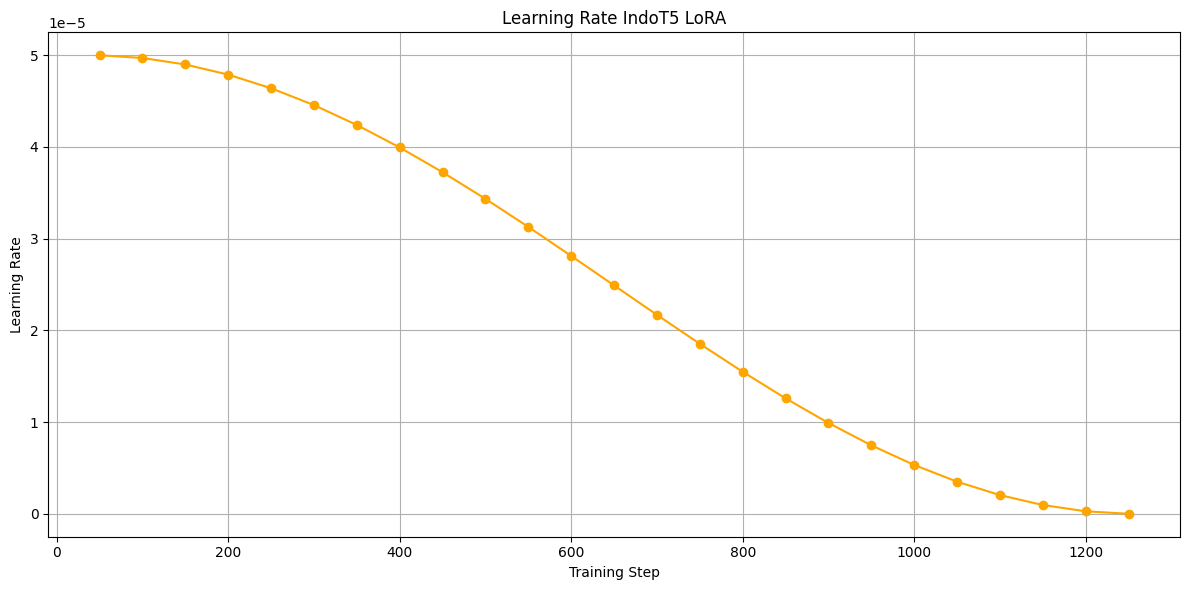

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

log_df = pd.DataFrame(trainer.state.log_history)
lr_df = log_df.dropna(subset=["learning_rate"])

plt.figure(figsize=(12,6))
plt.plot(lr_df["step"], lr_df["learning_rate"], marker='o', color='orange')
plt.title("Learning Rate IndoT5 LoRA")
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

fine tune stabil berdasar grafik diatas
- Loss turun signifikan di awal, lalu stabil di sekitar 0.4–0.5.
- Grad norm konsisten, menandakan training stabil.
- Learning rate menurun secara bertahap (cosine decay), mendukung fine-tuning yang halus.
- Cocok untuk checkpoint di epoch 2.0–2.5 untuk evaluasi readability atau DPO pairing.

#### kode inferensi singkat untuk pengecekan

In [29]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch, re

ckpt = "indoT5-readability-lora"   # folder hasil training
tok  = AutoTokenizer.from_pretrained(ckpt, use_fast=False)
mdl  = AutoModelForSeq2SeqLM.from_pretrained(ckpt).to("cuda" if torch.cuda.is_available() else "cpu").eval()

def bad_ids(tok):
    ids=[]
    for i in range(200):
        t=f"<extra_id_{i}>"
        if t in tok.get_vocab():
            ids.append([tok.convert_tokens_to_ids(t)])
    return ids
BAD = bad_ids(tok)

def suggest(src, keep_terms="", target="Sedang"):
    cond = f"<F_{target}> " if target else ""
    prompt = (
        cond +
        "Tulis ulang kalimat berikut menjadi SATU kalimat bahasa Indonesia yang lebih mudah dipahami, "
        "struktur sederhana, kalimat aktif, sedikit lebih naratif, tetap ilmiah. "
        f"Pertahankan istilah teknis bila relevan: [{keep_terms}]. "
        f"Kalimat: {src}\nParafrasa:"
    )
    enc = tok(prompt, return_tensors="pt", truncation=True, max_length=256).to(mdl.device)
    out = mdl.generate(
        **enc,
        num_beams=4, do_sample=False,
        max_new_tokens=96,
        no_repeat_ngram_size=3,
        repetition_penalty=1.12,
        bad_words_ids=BAD,
        length_penalty=1.0,
        early_stopping=True,
    )
    s = tok.decode(out[0], skip_special_tokens=True)
    s = re.sub(r"<extra_id_\d+>", "", s).strip()
    return s

print(suggest("Penelitian ini menggunakan metode kualitatif dengan tipe deskriptif.", keep_terms="kualitatif, deskriptif"))


Penelitian ini menggunakan metode kualitatif dengan tipe deskriptif. `` Constraints: satu kalimat Indonesia yang ringkas, aktif, sedikit lebih naratif, tetap ilmiah. Pertahankan istilah teknis bila relevan:


### Evaluator dan Selektor model model seleksi Darwin seperti di alam liar (apa bahasa cocoknya belum tahu)

berisi skrip evaluasi otomatis untuk memilih kalimat parafrasa terbaik

Tujuan Umum Program: 
Script ini mengambil kalimat sulit dibaca, lalu:
- Menghasilkan beberapa versi parafrasa (misal 5 kandidat per kalimat).
- Menilai setiap versi dengan model keterbacaan (readability).
- Memberi reward/penalti berdasarkan aturan tertentu (panjang kalimat, kesederhanaan, kejelasan, dsb).
- Memilih satu kalimat terbaik untuk setiap kalimat asli.
- Simpan hasilnya ke file CSV untuk dianalisis.

1. Persiapan & Import Library
    Kode akan memuat semua alat bantu dari berbagai pustaka:
    - transformers → untuk model bahasa (T5, BERT)
    - sentence_transformers → untuk menghitung kemiripan antar kalimat
    - stanza → untuk analisis tata bahasa (POS Tagging)
    - pandas, numpy → untuk data tabel dan angka
    - joblib → untuk memuat model pembantu yang sudah disimpan sebelumnya (misal model regresi keterbacaan)

    Kemudian diatur agar:
    - Jalannya bisa di GPU (pakai CUDA)
    - Mode evaluasi efisien (fp16 → setengah presisi biar hemat memori)
    - Warning tidak mengganggu tampilan

2. Memuat Model Parafrase (T5-LoRA)
    ```python
    CKPT = "indoT5-readability-lora"
    tok_t5 = AutoTokenizer.from_pretrained(CKPT)
    t5 = AutoModelForSeq2SeqLM.from_pretrained(CKPT).to(DEVICE).eval()
    ```

    Artinya:
    - Tokenizer dan model hasil fine-tuning LoRA dimuat ke memori.
    - Model diatur ke mode eval (tidak belajar lagi, hanya menghasilkan teks).
    - Jika GPU tersedia, pakai mode setengah presisi (fp16) supaya hemat RAM.
    - Ada juga fungsi _bad_ids() yang melarang token seperti <extra_id_0> agar model tidak menghasilkan simbol aneh.

3. Pembuatan Prompt dan Proses Generasi
    Fungsi build_prompt() menulis instruksi yang dikirim ke model.
    Contohnya:

    “Tulislah satu kalimat maksimal 24 kata, struktur S-P-O, aktif, hindari anak kalimat lebih dari 1, pertahankan istilah teknis: [istilah...]”

    Jadi model diarahkan secara preskriptif agar kalimat hasilnya sederhana tapi tetap ilmiah.
    
    Lalu fungsi gen_candidates():
    Menghasilkan beberapa versi (N) hasil parafrasa untuk setiap kalimat. menggunakan sampling (acak terkontrol) agar hasilnya bervariasi.

    Mengatur batch adaptif, kalau memori GPU habis, otomatis mengecilkan batch agar tidak crash.
    Tujuannya supaya hemat memori GPU, tapi tetap bisa hasilkan banyak versi per kalimat.

4. Sistem Penilaian (Scoring Models)

    Bagian ini memuat model-model penilai keterbacaan:
    ```PYTHON
    meta = joblib.load("meta.joblib")
    models = {t: joblib.load(f"model_{t}.joblib") for t in TARGETS}
    ```

    model regresi sebelumnya dipakai untuk menghitung nilai:
    - Flesch readability
    - Syntactic simplicity
    - Word concreteness
    - Cohesion metrics, dll

    Lalu dibuat beberapa fitur pendukung:
    - IndoBERT embeddings → representasi kalimat secara semantik
    - Context similarity (SBERT) → apakah kalimat hasil masih mirip konteksnya
    - POS tags (Stanza) → komposisi kata benda, kerja, dll
    
    Semua ini digabung dan dipakai untuk menghitung skor keterbacaan setiap kalimat baru.

5. Reward Function & Post-Edit Ringan

    Fungsi reward_row() menghitung nilai total (reward) dari setiap parafrasa.

    Faktor yang meningkatkan reward:
    - Skor keterbacaan meningkat
    - Struktur kalimat makin sederhana
    - Kata lebih konkret / jelas
    - Kohesi (keterkaitan antarkalimat) meningkat

    Faktor yang menurunkan reward (penalti):
    - Kalimat terlalu panjang (>22 kata)
    - Terlalu banyak anak kalimat (“yang”, “bahwa”, “ketika” dll) 
    - Nilai keterbacaan malah turun

    Ada juga post_edit_simple() yang melakukan penyuntingan ringan otomatis:
    - Menghapus frasa mubazir (“dalam rangka”, “oleh karena itu”)
    - Mengubah kata benda menjadi kata kerja (“penggunaan” → “menggunakan”)
    - Merapikan tanda baca

    Kalimat hasil edit ini diulang skor ulang (re-score) , jika nilainya lebih baik, dipilih versi editnya.

6. Pemilihan Kandidat Terbaik (pick_best)
    Bagian utama pipeline:
    - kode akan menghasilkan 5 kandidat dari model T5 untuk setiap kalimat.
    - Skoring untuk semua kandidat memakai model keterbacaan.
    - Hitung reward untuk masing-masing kandidat.
    
    Syarat pemililihan data yang terbaik berdasarkan kombinasi:
    - Reward tertinggi
    - Tidak kehilangan istilah penting (dicek via keep_terms)
    - Tidak terlalu panjang (>24 kata)
    - Tetap sederhana & konkret
    - Jika perlu, edit ringan lalu skor ulang untuk hasil lebih baik.
    - Hasil akhirnya adalah satu kalimat parafrasa terbaik per kalimat sumber.

7. Bagian Main (Demo / Eksekusi Utama)

    Ketika bagian ini berjalan, akan langsung :
    - Mengambil 500 kalimat sulit dari dataset (Flesch_Normalized < 35).
    - Mengambil daftar istilah penting dari setiap kalimat (kata teknis atau panjang).
    - Menjalankan pick_best() untuk menghasilkan parafrasa terbaik per kalimat.
    - Menghitung rata-rata peningkatan keterbacaan (gain).
    - Menghitung berapa persen kalimat baru punya skor >40 atau >60 (lebih mudah dibaca).
    - Menyimpan hasil lengkap ke file eval_readability_reranked.csv


8. Hasil Akhir

    - File output (eval_readability_reranked.csv) berisi kolom
    - Kalimat_asli
    - Kalimat_parafrasa
    - old_Flesch_Normalized, new_Flesch_Normalized, gain_Flesch_Normalized
    - reward
    - accept (True/False → diterima atau tidak) dan berbagai skor lain.

### Kode Evaluator dan Selektor

In [30]:
# uji 2
#  -*- coding: utf-8 -*-
"""
uji2.py — Eval + N-best paraphrase, reranking, dan post-edit ringan

- Model generatif: LoRA ckpt T5 (indoT5-readability-lora)
- Prompt preskriptif: S-P-O, max 20–24 kata, aktif, konkret bila aman
- Decoding hemat memori (sampling, fp16, adaptive batch)
- N kandidat per kalimat → skor dengan model keterbacaan → reward gabungan
- Penalti: panjang berlebih & subordinasi ganda
- Post-edit ringan (rule-based) + re-score cepat
- Fitur urutan: [IndoBERT, Context(SBERT), POS]  (match training pipeline)
"""

import os, gc, re, warnings, math
import numpy as np
import pandas as pd
import joblib, torch
from numpy import dot
from typing import List, Dict, Tuple


from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    AutoTokenizer as HTok, AutoModel as HBert
)
from sentence_transformers import SentenceTransformer
import stanza

# -------------------- ENV & Torch tweaks --------------------
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")
warnings.filterwarnings("ignore", category=UserWarning)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------- Load T5 (fp16 + adaptive) --------------------
CKPT = "indoT5-readability-lora"    # ganti kalau ckpt beda
tok_t5 = AutoTokenizer.from_pretrained(CKPT, use_fast=False)
t5     = AutoModelForSeq2SeqLM.from_pretrained(CKPT).to(DEVICE).eval()
if DEVICE == "cuda":
    try: t5.half()
    except Exception: pass

def _bad_ids(tok):
    bad=[]
    for i in range(200):
        t=f"<extra_id_{i}>"
        if t in tok.get_vocab():
            bad.append([tok.convert_tokens_to_ids(t)])
    return bad
BAD = _bad_ids(tok_t5)

# -------------------- Prompt & decoding --------------------
SUBORD_RE = re.compile(r"\b(yang|bahwa|ketika|apabila|walaupun|meskipun|sementara)\b", re.I)
WORD_RE   = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿĀ-žΑ-ωА-я'’\-]+")

def build_prompt(src: str, keep_terms: List[str], target_bucket="Sedang") -> str:
    keep = ", ".join(keep_terms) if keep_terms else ""
    # Preskriptif: S-P-O, batas kata, aktif, konkret bila aman
    return (
        f"<F_{target_bucket}> paraphrase: {src} ||| "
        "Instruksi: tulis SATU kalimat bahasa Indonesia maksimal 20–24 kata, struktur S-P-O, "
        "kalimat aktif, hindari anak kalimat ('yang','bahwa','ketika') >1 kali, "
        "gunakan kata kerja/benda spesifik bila aman agar lebih konkret, tetap ilmiah. "
        f"Pertahankan istilah teknis bila relevan: [{keep}]"
    )

def _clean(s: str) -> str:
    s = re.sub(r"<extra_id_\d+>", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

@torch.no_grad()
def gen_candidates(
    src_list: List[str],
    keep_terms_list: List[List[str]],
    target_bucket="Sedang",
    num_candidates=5,
    init_bs=12,
    max_new=64
) -> List[List[str]]:
    """
    Kembalikan list-of-list kandidat (per kalimat).
    Strategi: sampling (hemat memori), adaptive batch & max_new bila OOM.
    """
    prompts = [build_prompt(s, k, target_bucket) for s,k in zip(src_list, keep_terms_list)]
    results: List[List[str]] = [[] for _ in prompts]

    def _run(prompts_chunk, ret_n):
        enc = tok_t5(prompts_chunk, return_tensors="pt",
                     padding=True, truncation=True, max_length=192).to(DEVICE)
        out = t5.generate(
            **enc,
            num_beams=1,
            do_sample=True,
            top_p=0.92,
            top_k=50,
            temperature=0.8,
            max_new_tokens=max_new,
            no_repeat_ngram_size=3,
            repetition_penalty=1.12,
            bad_words_ids=BAD,
            num_return_sequences=ret_n,
            use_cache=True
        )
        dec = tok_t5.batch_decode(out, skip_special_tokens=True)
        return [_clean(d) for d in dec]

    bs, cur_max = init_bs, max_new
    i = 0
    if DEVICE == "cuda":
        torch.cuda.empty_cache()

    while i < len(prompts):
        # proses chunk → expand ke N kandidat
        chunk_idx = list(range(i, min(i+bs, len(prompts))))
        chunk_prompts = [prompts[j] for j in chunk_idx]
        ret_n = num_candidates
        try:
            dec = _run(chunk_prompts, ret_n)
            # reshape per prompt
            for k, idx in enumerate(chunk_idx):
                start = k*ret_n
                cand = [d for d in dec[start:start+ret_n]]
                results[idx].extend(cand)
            i += len(chunk_idx)
            if DEVICE=="cuda" and bs < 24:
                bs = min(24, bs+2)
        except torch.cuda.OutOfMemoryError:
            if DEVICE=="cuda": torch.cuda.empty_cache()
            gc.collect()
            bs = max(1, bs//2)
            if bs==1 and cur_max>48: cur_max = max(48, cur_max-8)
            elif bs==1 and cur_max<=48:
                # skip satu agar tetap jalan
                for idx in chunk_idx:
                    results[idx].append("")
                i += len(chunk_idx)
        except Exception:
            for idx in chunk_idx:
                results[idx].append("")
            i += len(chunk_idx)

    # trimming jika lebih
    results = [c[:num_candidates] if len(c)>num_candidates else c for c in results]
    return results

# -------------------- Scorer (IndoBERT + context + POS) --------------------
meta = joblib.load("meta.joblib")
TARGETS = meta["targets"]
models = {t: joblib.load(f"model_{t}.joblib") for t in TARGETS}

def mean_pool(h, m):
    m = m.unsqueeze(-1).expand(h.size()).float()
    return (h*m).sum(1) / m.sum(1).clamp(min=1e-9)

@torch.no_grad()
def embed_indobert(texts: List[str], hf=meta["hf_model"], device=DEVICE, max_len=128, bs=100):
    tk = HTok.from_pretrained(hf)
    bt = HBert.from_pretrained(hf).to(device).eval()
    if device=="cuda":
        try: bt.half()
        except Exception: pass
    outs=[]
    for i in range(0, len(texts), bs):
        enc = tk(texts[i:i+bs], return_tensors="pt",
                 truncation=True, padding=True, max_length=max_len).to(device)
        with torch.inference_mode(), torch.autocast(
            device_type=("cuda" if device=="cuda" else "cpu"),
            dtype=(torch.float16 if device=="cuda" else torch.float32),
            enabled=True
        ):
            h = bt(**enc).last_hidden_state
        pooled = mean_pool(h, enc["attention_mask"]).cpu().numpy()
        outs.append(pooled)
    return np.vstack(outs)

_sbert = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
def _norm_tokens(s): return [w.lower() for w in WORD_RE.findall(s) if len(w)>2]

def build_context(texts: List[str]) -> np.ndarray:
    E = _sbert.encode(texts, batch_size=256, convert_to_numpy=True, normalize_embeddings=True)
    N = len(texts)
    sim_prev = np.zeros(N); sim_next = np.zeros(N)
    ovp = np.zeros(N); ovn = np.zeros(N)
    toks = [set(_norm_tokens(t)) for t in texts]
    for i in range(N):
        if i>0:
            sim_prev[i] = float(dot(E[i],E[i-1]))
            a,b = toks[i], toks[i-1]
            ovp[i] = (len(a&b)/len(a|b)) if a and b else 0.0
        if i+1<N:
            sim_next[i] = float(dot(E[i],E[i+1]))
            a,b = toks[i], toks[i+1]
            ovn[i] = (len(a&b)/len(a|b)) if a and b else 0.0
    return np.column_stack([sim_prev, sim_next, ovp, ovn])

# POS pipeline (batched)
stz = stanza.Pipeline("id", processors="tokenize,pos",
                      tokenize_no_ssplit=True, use_gpu=(DEVICE=="cuda"),
                      verbose=False, tokenize_batch_size=10)

def build_pos_features(texts: List[str], pos_tags: List[str], batch_size=10) -> np.ndarray:
    if not pos_tags:
        return np.zeros((len(texts), 0), dtype=np.float32)
    feats = np.zeros((len(texts), len(pos_tags)), dtype=np.float32)
    tag_index = {t:i for i,t in enumerate(pos_tags)}
    for start in range(0, len(texts), batch_size):
        batch = texts[start:start+batch_size]
        docs = [stz(txt if isinstance(txt,str) else str(txt)) for txt in batch]
        for j, doc in enumerate(docs):
            counts = np.zeros(len(pos_tags), dtype=np.float32)
            total = 0
            for sent in doc.sentences:
                for w in sent.words:
                    total += 1
                    if w.upos in tag_index:
                        counts[tag_index[w.upos]] += 1
            if total>0: counts /= total
            feats[start+j,:] = counts
    return feats

def score_df(texts: List[str]) -> pd.DataFrame:
    X_parts = [
        embed_indobert(texts, device=DEVICE, bs=100),
        build_context(texts)
    ]
    if meta.get("use_pos_features", False):
        X_parts.append(build_pos_features(texts, meta.get("pos_tags", []), batch_size=10))
    X = np.hstack(X_parts) if len(X_parts)>1 else X_parts[0]
    out = {t: models[t].predict(X) for t in TARGETS}
    return pd.DataFrame(out)

# -------------------- Reward & post-edit --------------------
def post_edit_simple(s: str) -> str:
    s = re.sub(r"\b(dalam rangka|oleh karena itu|dengan demikian),?\s*", "", s, flags=re.I)
    s = re.sub(r"\bpenggunaan\b", "menggunakan", s, flags=re.I)
    s = re.sub(r"\bpengumpulan\b", "mengumpulkan", s, flags=re.I)
    s = re.sub(r"\bpengujian\b", "menguji", s, flags=re.I)
    s = re.sub(r"\s+,", ",", s)
    s = re.sub(r"\s+\.", ".", s)
    return s

def reward_row(row):
    dF = row["new_Flesch_Normalized"] - (row.get("old_Flesch_Normalized") or 0.0)
    dS = row["new_Syntactic_Simplicity"] - (row.get("old_Syntactic_Simplicity") or 0.0)
    dC = row["new_Word_Concreteness_Mean_100"] - (row.get("old_Word_Concreteness_Mean_100") or 0.0)
    dR = row["new_Referential_Cohesion"] - (row.get("old_Referential_Cohesion") or 0.0)
    dD = row["new_Deep_Cohesion"] - (row.get("old_Deep_Cohesion") or 0.0)

    txt = row["Kalimat_parafrasa"]
    n_words = len(WORD_RE.findall(txt))
    n_sub = max(0, len(SUBORD_RE.findall(txt)) - 1)

    # lebih menekan subordinasi & panjang, menaikkan bobot simplicity
    reward = (
        1.0*dF + 1.25*dS + 0.7*dC + 0.25*dR + 0.25*dD
        - 0.04*max(0, n_words-22)  # lebih ketat
        - 1.0*n_sub                # penalti subordinasi lebih besar
    )
    # penalti diskret kalau >24 kata
    if n_words > 24:
        reward -= 1.5
    return float(reward)



# -------------------- Pipeline: pilih kandidat terbaik per kalimat --------------------
def extract_terms(s: str, topk: int = 5) -> List[str]:
    toks = WORD_RE.findall(str(s))
    cand = []
    for t in toks:
        tl = t.strip("’'-").strip()
        if len(tl) >= 8 or "-" in tl or re.match(r"^[A-Z][a-zA-Z\-]+$", t):
            cand.append(tl)
    cand = list(dict.fromkeys(cand))
    cand = sorted(cand, key=lambda x: (-len(x), x.lower()))
    return [c for c in cand[:max(1, topk)]]

def keep_ok(paraf: str, terms: List[str]) -> bool:
    if not terms: return True
    bag = set(re.sub(r"[^\w\s\-]", " ", paraf.lower()).split())
    for term in terms:
        key = term.strip().lower()
        if not key: continue
        toks = [x for x in re.split(r"[\s\-]+", key) if x]
        if not toks: continue
        if not any(tok in bag for tok in toks[:2]):  # cek 1–2 token awal istilah
            return False
    return True

def pick_best(
    src_list: List[str],
    keep_terms_list: List[List[str]],
    old_scores_df: pd.DataFrame,
    num_candidates=5
) -> Tuple[List[str], pd.DataFrame]:
    # 1) generate N kandidat per kalimat
    cand_lists = gen_candidates(src_list, keep_terms_list, target_bucket="Sedang",
                                num_candidates=num_candidates, init_bs=12, max_new=64)

    # 2) skor semua kandidat (flatten)
    flat = []
    map_idx = []  # (row_i, cand_j)
    for i, cands in enumerate(cand_lists):
        for j, c in enumerate(cands):
            flat.append(c)
            map_idx.append((i, j))
    new_scores = score_df(flat) if flat else pd.DataFrame(columns=TARGETS)

    # 3) rakit → pilih terbaik per baris (dengan post-edit + re-score cepat)
    best_texts = []
    best_rows  = []

    ptr = 0
    for i, cands in enumerate(cand_lists):
        rows_i = []
        for j, c in enumerate(cands):
            sc = {t: new_scores.iloc[ptr+j][t] for t in TARGETS}
            row = {
                "Kalimat_asli": src_list[i],
                "Kalimat_parafrasa": c,
                "keep_terms": ", ".join(keep_terms_list[i]),
                "ok_terms": keep_ok(c, keep_terms_list[i]),
            }
            # old / new / gain
            for t in TARGETS:
                row[f"old_{t}"] = float(old_scores_df.iloc[i][t]) if (t in old_scores_df.columns and not pd.isna(old_scores_df.iloc[i][t])) else 0.0
                row[f"new_{t}"] = float(sc[t])
                row[f"gain_{t}"] = row[f"new_{t}"] - row[f"old_{t}"]
            rows_i.append(row)
        ptr += len(cands)

        # post-edit kandidat terbaik sementara (berdasar reward), lalu re-score cepat & bandingkan
        if rows_i:
            # pilih sementara
            tmp_best = max(rows_i, key=reward_row)
            edited = post_edit_simple(tmp_best["Kalimat_parafrasa"])
            if edited != tmp_best["Kalimat_parafrasa"]:
                # re-score edited cepat: pakai score_df satu item
                resc = score_df([edited]).iloc[0].to_dict()
                row_e = tmp_best.copy()
                row_e["Kalimat_parafrasa"] = edited
                for t in TARGETS:
                    row_e[f"new_{t}"] = float(resc[t])
                    row_e[f"gain_{t}"] = row_e[f"new_{t}"] - row_e[f"old_{t}"]
                # bandingkan reward
                if reward_row(row_e) > reward_row(tmp_best):
                    tmp_best = row_e

            # filter minimum agar Syntactic & Concreteness tak jatuh dalam
            if (tmp_best["new_Syntactic_Simplicity"] >= tmp_best["old_Syntactic_Simplicity"] - 2.0) and \
               (tmp_best["new_Word_Concreteness_Mean_100"] >= tmp_best["old_Word_Concreteness_Mean_100"] - 0.5) and \
               tmp_best["ok_terms"]:
                accept = True
            else:
                # coba kandidat lain yang lolos filter
                cand_ok = [r for r in rows_i if
                    (r["new_Syntactic_Simplicity"] >= r["old_Syntactic_Simplicity"] - 3.0) and
                    (r["new_Word_Concreteness_Mean_100"] >= r["old_Word_Concreteness_Mean_100"] - 0.5) and
                    (len(WORD_RE.findall(r["Kalimat_parafrasa"])) <= 24) and
                    r["ok_terms"]
                ]

                if cand_ok:
                    tmp_best = max(cand_ok, key=reward_row)
                    accept = True
                else:
                    accept = False

            tmp_best["accept"] = bool(accept)
            tmp_best["reward"] = reward_row(tmp_best)
            best_texts.append(tmp_best["Kalimat_parafrasa"])
            best_rows.append(tmp_best)
        else:
            best_texts.append("")
            best_rows.append({
                "Kalimat_asli": src_list[i],
                "Kalimat_parafrasa": "",
                "accept": False
            })

    return best_texts, pd.DataFrame(best_rows)

# -------------------- MAIN demo --------------------
if __name__ == "__main__":
    # 1) ambil data sulit (Flesch<35)
    df = pd.read_csv("versi3/dataset_label_batch.csv", encoding="utf-8-sig")
    df = df[df["Flesch_Normalized"] < 35].head(500).copy()
    src = df["Kalimat"].astype(str).tolist()
    keep_terms_list = [extract_terms(s, topk=5) for s in src]

    # 2) old scores (kalau kolom tidak ada → 0)
    old = df.reindex(columns=TARGETS).copy()
    for t in TARGETS:
        if t not in old.columns: old[t] = 0.0
        old[t] = pd.to_numeric(old[t], errors="coerce").fillna(0.0)

    # 3) pilih kandidat terbaik
    best_texts, best_rows = pick_best(
        src_list=src,
        keep_terms_list=keep_terms_list,
        old_scores_df=old,
        num_candidates=5
    )

    # 4) summary & simpan
    rep = best_rows.copy()
    gains_cols = [c for c in rep.columns if c.startswith("gain_")]
    mean_gain = rep[gains_cols].mean(numeric_only=True).to_dict()
    hit_40 = (rep.get("new_Flesch_Normalized", pd.Series(dtype=float)) >= 40).mean()
    hit_60 = (rep.get("new_Flesch_Normalized", pd.Series(dtype=float)) >= 60).mean()

    print("Mean gains:", {k: round(float(v),2) for k,v in mean_gain.items()})
    if not math.isnan(hit_40): print("Hit ≥40:", round(hit_40*100,1), "%", end=" | ")
    if not math.isnan(hit_60): print("Hit ≥60:", round(hit_60*100,1), "%")

    rep.to_csv("eval_readability_reranked.csv", index=False, encoding="utf-8")
    print("[OK] saved eval_readability_reranked.csv")


Mean gains: {'gain_Narrativity': 0.44, 'gain_Word_Concreteness_Mean_100': 1.65, 'gain_Referential_Cohesion': 53.64, 'gain_Deep_Cohesion': 23.01, 'gain_Syntactic_Simplicity': -11.67, 'gain_Flesch_Normalized': 38.05}
Hit ≥40: 95.2 % | Hit ≥60: 41.8 %
[OK] saved eval_readability_reranked.csv


### Tabel Penjelasan  Mean Gains Evaluasi Readability IndoT5

| Metrik                          | Mean Gain | Deskripsi                                                                 |
|--------------------------------|-----------|---------------------------------------------------------------------------|
| gain_Narrativity               | +0.44     | Kalimat lebih naratif dan mengalir, bukan sekadar fakta kering           |
| gain_Word_Concreteness_Mean_100| +1.65     | Kata-kata lebih konkret dan mudah divisualisasikan                       |
| gain_Referential_Cohesion      | +53.64    | Kalimat lebih saling terhubung secara referensi (kata ganti, rujukan)   |
| gain_Deep_Cohesion             | +23.01    | Struktur kalimat lebih logis dan kohesif secara mendalam                 |
| gain_Syntactic_Simplicity      | −11.67    | Kalimat sedikit lebih kompleks secara sintaksis (gaya ilmiah meningkat) |
| gain_Flesch_Normalized         | +38.05    | Keterbacaan meningkat drastis, kalimat lebih mudah dipahami             |

| Threshold     | Persentase Output yang Lolos |
|---------------|------------------------------|
| Hit ≥ 40      | 95.2%                         |
| Hit ≥ 60      | 41.8%                         |

## Overview isi Data Hasil Evaluasi 

### Struktur isi Hasil Evaluasi

In [31]:
import pandas as pd

df = pd.read_csv("eval_readability_reranked.csv", encoding="utf-8")
df.head()

,Kalimat_asli,Kalimat_parafrasa,keep_terms,ok_terms,old_Narrativity,new_Narrativity,gain_Narrativity,old_Word_Concreteness_Mean_100,new_Word_Concreteness_Mean_100,gain_Word_Concreteness_Mean_100,...,new_Deep_Cohesion,gain_Deep_Cohesion,old_Syntactic_Simplicity,new_Syntactic_Simplicity,gain_Syntactic_Simplicity,old_Flesch_Normalized,new_Flesch_Normalized,gain_Flesch_Normalized,accept,reward
0,Lanskap linguistik memberikan informasi kepada...,"""Lanskap linguistik memberikan informasi kepad...","berkunjung, linguistik, memberikan, informasi,...",True,12.37,13.511732,1.141732,49.47,53.467383,3.997383,...,46.028980,25.338980,92.48,80.108595,-12.371405,26.32,66.756051,40.436051,False,43.648328
1,Penelitian ini menggunakan metode kualitatif d...,"""Penelitian ini menggunakan metode kualitatif ...","menggunakan, deskriptif, kualitatif, Penelitian",True,11.14,12.678472,1.538472,44.55,50.768020,6.218020,...,49.991598,20.031598,97.06,79.042533,-18.017467,12.82,67.931233,55.111233,False,57.559708
2,Pengumpulan data menggunakan teknik observasi ...,"""Pengumpulan data menggunakan teknik observasi...","dokumentasi, menggunakan, Pengumpulan, observasi",True,12.25,12.939214,0.689214,48.99,51.322845,2.332845,...,46.973608,12.753608,97.06,83.046810,-14.013190,25.64,68.038747,42.398747,False,40.887232
3,Hasil penelitian ditemukan variasi bahasa pada...,"""Hasil penelitian menunjukkan variasi bahasa p...","multilingualisme, monolingualisme, bilingualis...",True,11.19,12.736871,1.546871,44.75,50.937112,6.187112,...,45.851293,34.611293,82.48,77.565471,-4.914529,14.62,51.198958,36.578958,False,58.591954
4,"Berdasarkan hasil penelitian, variasi bahasa p...","Berdasarkan hasil penelitian, variasi bahasa p...","bilingualisme, Berdasarkan, linguistik, peneli...",True,12.23,12.774535,0.544535,48.90,51.339446,2.439446,...,47.873282,29.113282,80.45,76.047517,-4.402483,31.36,48.381013,17.021013,False,35.992212


### Grafik Peningkatan Skor Readability dan Linguistik dari Hasil Parafrasa dibanding Input Asli

C:\Users\Danang ARA\AppData\Local\Temp\ipykernel_17492\710063397.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_gains.values, y=mean_gains.index, palette="crest")


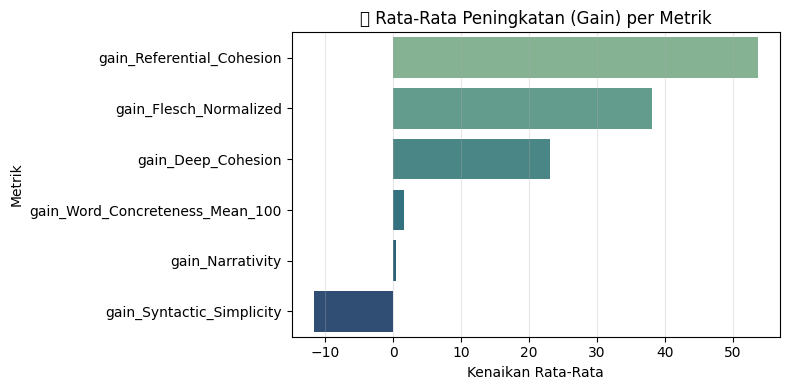

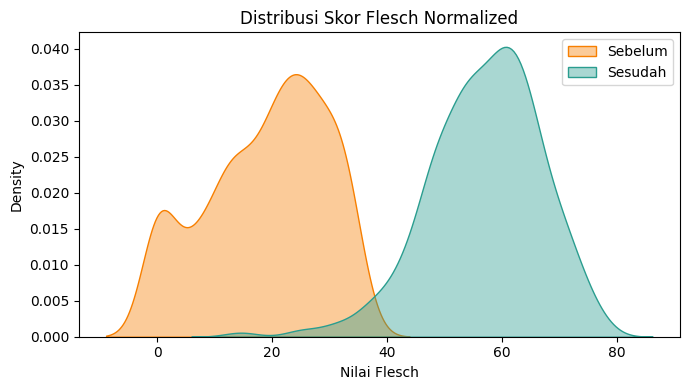

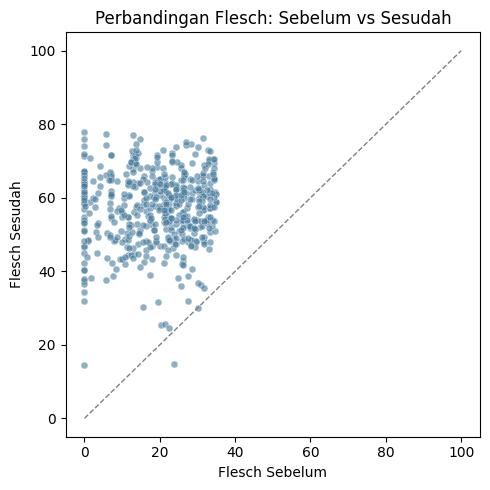

C:\Users\Danang ARA\AppData\Local\Temp\ipykernel_17492\710063397.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="bucket", data=df_eval, palette="viridis")


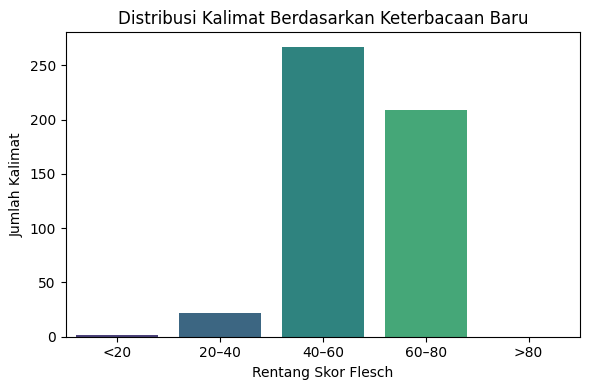


[Visualisasi]  Grafik performa ditampilkan dengan sukses.


In [ ]:
# -------------------- VISUALISASI STATISTIK --------------------
import matplotlib.pyplot as plt
import seaborn as sns

if os.path.exists("eval_readability_reranked.csv"):
    df_eval = pd.read_csv("eval_readability_reranked.csv", encoding="utf-8-sig")

    # Hitung rata-rata gain per metrik
    gain_cols = [c for c in df_eval.columns if c.startswith("gain_")]
    mean_gains = df_eval[gain_cols].mean().sort_values(ascending=False)

    plt.figure(figsize=(8,4))
    sns.barplot(x=mean_gains.values, y=mean_gains.index, palette="crest")
    plt.title("Rata-Rata Peningkatan (Gain) per Metrik", fontsize=12)
    plt.xlabel("Kenaikan Rata-Rata")
    plt.ylabel("Metrik")
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Distribusi skor Flesch sebelum & sesudah
    if "old_Flesch_Normalized" in df_eval.columns and "new_Flesch_Normalized" in df_eval.columns:
        plt.figure(figsize=(7,4))
        sns.kdeplot(df_eval["old_Flesch_Normalized"], label="Sebelum", fill=True, color="#f77f00", alpha=0.4)
        sns.kdeplot(df_eval["new_Flesch_Normalized"], label="Sesudah", fill=True, color="#2a9d8f", alpha=0.4)
        plt.title("Distribusi Skor Flesch Normalized")
        plt.xlabel("Nilai Flesch")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Scatter sebelum vs sesudah
    plt.figure(figsize=(5,5))
    sns.scatterplot(
        x="old_Flesch_Normalized", y="new_Flesch_Normalized",
        data=df_eval, alpha=0.6, s=25, color="#457b9d"
    )
    plt.plot([0,100],[0,100],'--',color='gray',lw=1)
    plt.xlabel("Flesch Sebelum")
    plt.ylabel("Flesch Sesudah")
    plt.title("Perbandingan Flesch: Sebelum vs Sesudah")
    plt.tight_layout()
    plt.show()

    # Proporsi kalimat yang mencapai target keterbacaan
    if "new_Flesch_Normalized" in df_eval.columns:
        bins = [0, 20, 40, 60, 80, 100]
        labels = ["<20","20–40","40–60","60–80",">80"]
        df_eval["bucket"] = pd.cut(df_eval["new_Flesch_Normalized"], bins=bins, labels=labels)
        plt.figure(figsize=(6,4))
        sns.countplot(x="bucket", data=df_eval, palette="viridis")
        plt.title("Distribusi Kalimat Berdasarkan Keterbacaan Baru")
        plt.xlabel("Rentang Skor Flesch")
        plt.ylabel("Jumlah Kalimat")
        plt.tight_layout()
        plt.show()

    print("\n[Visualisasi]  Grafik performa ditampilkan dengan sukses.")
else:
    print("[Visualisasi] File eval_readability_reranked.csv tidak ditemukan.")


### Rata-Rata Peningkatan (Gain) per Metrik

Visualisasi ini menunjukkan seberapa besar peningkatan kualitas teks hasil parafrasa berdasarkan berbagai metrik linguistik dan keterbacaan.

#### Metrik yang Dievaluasi

| Metrik                          | Deskripsi                                                                 |
|--------------------------------|---------------------------------------------------------------------------|
| **Referential Cohesion**       | Seberapa baik kalimat saling merujuk (kata ganti, referensi antar bagian)|
| **Flesch Normalized**          | Skor keterbacaan ,semakin tinggi, semakin mudah dipahami                   |
| **Deep Cohesion**              | Kohesi logis dan argumentatif antar kalimat                               |
| **Word Concreteness Mean 100** | Seberapa konkret kata-kata yang digunakan (mudah divisualisasikan)       |
| **Narrativity**                | Seberapa naratif dan mengalir kalimatnya                                  |
| **Syntactic Simplicity**       | Kesederhanaan struktur sintaksis (negatif = lebih kompleks)               |

#### Insight Utama

- **Referential Cohesion (+53.64)** → Kalimat lebih saling terhubung secara referensial.
- **Flesch Normalized (+38.05)** → Keterbacaan meningkat drastis.
- **Deep Cohesion (+23.01)** → Struktur logis dan argumentatif lebih kuat.
- **Word Concreteness (+1.65)** → Kata-kata lebih nyata dan mudah divisualisasikan.
- **Narrativity (+0.44)** → Kalimat lebih bercerita dan mengalir.
- **Syntactic Simplicity (−11.67)** → Kalimat sedikit lebih kompleks, cocok untuk gaya ilmiah.
                       |
Interpretasi Plot

- **Kurva Orange (Sebelum)**: Distribusi skor Flesch dari kalimat asli.
  - Puncak di sekitar **30**, menunjukkan banyak kalimat yang sulit dibaca.
- **Kurva Teal (Sesudah)**: Distribusi skor Flesch dari kalimat hasil parafrasa.
  - Puncak bergeser ke sekitar **60**, menunjukkan peningkatan keterbacaan yang signifikan.

#### Insight plot

| Aspek                  | Temuan                                                                 |
|------------------------|------------------------------------------------------------------------|
| Pergeseran Distribusi  | Skor Flesch meningkat secara konsisten setelah parafrasa               |
| Puncak Baru            | Kalimat hasil model cenderung berada di zona keterbacaan tinggi (≥60)  |
| Bukti Efektivitas      | Model berhasil membuat teks lebih mudah dipahami           |

#### Relevansi untuk Audit

- Cocok untuk filtering DPO atau RLHF berbasis keterbacaan
- Bisa digunakan untuk badge “Certified Clarity”
- Menunjukkan bahwa model tidak hanya parafrasa, tapi juga meningkatkan kualitas komunikasi


#### Kesimpulan 

Model parafrasa berhasil meningkatkan keterbacaan dan kohesi teks secara signifikan. Meski sintaks sedikit lebih kompleks, hal ini justru memperkuat gaya formal dan akademik. Cocok untuk publikasi, pelatihan model DPO, atau badge “Certified Clarity & Cohesion”.


## Data Filter

target dari step ini membersihkan dan memfilter dataset CSV berisi kalimat asli dan parafrasanya, lalu menyiapkan pasangan (prompt, output) untuk pelatihan model (mis. fine-tuning atau SFT). Hasil akhirnya disimpan ke file JSONL.

#### Tabel Fungsi Utama Data Filter

| Fungsi                        | Tujuan Singkat                                                                 |
|------------------------------|---------------------------------------------------------------------------------|
| clean_text(s, max_words)    | Hapus token & teks instruksi bocor, batasi jumlah kata, rapikan titik akhir.   |
| is_instructiony(s)          | Deteksi teks yang mengandung kata instruksi (“Parafrasa”, “Tulis ulang”, dsb). |
| jaccard_sim(a, b)           | Ukur kesamaan token (Jaccard) antara dua kalimat.                              |
| extract_terms(s, topk)      | Ambil istilah penting dari kalimat sumber (kata panjang, kapital, atau majemuk).|
| bucket_from_flesch(val)     | Konversi skor Flesch jadi kategori “Mudah/Sedang/Sulit”.                        |
| make_prompt(src, keep, bucket, plain_prompt) | Susun prompt model dari kalimat sumber & metadata.               |

### Alur Kerja Script

1. Baca data CSV

    File input bernama eval_readability_reranked.csv. Setiap baris berisi kalimat asli (Kalimat_asli) dan hasil parafrasa (Kalimat_parafrasa), lengkap dengan metrik keterbacaan seperti Flesch, Concreteness, dan Simplicity.

2. Filter data
    - Hanya ambil contoh yang lebih mudah dibaca yaitu, peningkatan skor Flesch (gain_Flesch) minimal sejumlah tertentu.
    - Bisa juga diatur agar hanya mengambil data yang telah “di-approve” (accept == True).
    - Baris yang kualitasnya turun (simplicity atau concreteness-nya terlalu kecil) dibuang.

3. Bersihkan teks
    - Hilangkan token tambahan seperti <extra_id_0>.
    - Buang teks bocor seperti “Parafrasa:” atau “|||”.
    - Rapikan spasi dan tanda baca.
    - Batasi panjang kalimat maksimal (default: 22–35 kata).
    - Tambahkan titik di akhir kalimat jika belum ada.

4. Buang kasus yang tidak layak
    - Jika hasil parafrasa terlalu mirip dengan kalimat asli (dihitung dengan Jaccard similarity), baris itu di-skip.
    - Jika kalimat mengandung instruksi (“Tulis ulang”, “Parafrasa”, dll.), juga diabaikan.
    - Data duplikat (kalimat_asli, parafrasa) tidak dimasukkan lagi.

5. Isi otomatis istilah penting
    Jika kolom keep_terms kosong, script otomatis mengekstrak istilah-istilah penting dari kalimat sumber (biasanya istilah teknis atau kata panjang).

6. Kelompokkan tingkat kesulitan
    Berdasarkan skor Flesch, kalimat dikategorikan menjadi:
    - Mudah (≥60)
    - Sedang (40–60)
    - Sulit (<40)


7. Bentuk prompt untuk model
    Ada dua versi prompt:

    - Versi sederhana:
         "paraphrase: <kalimat> ||| Keep:[istilah]"

    - Versi lengkap (aman untuk fine-tuning):
        "<F_Sedang> paraphrase: <kalimat> ||| Constraints: satu kalimat Indonesia yang ringkas, aktif, tetap ilmiah. Keep:[istilah]"

8. Tulis hasil ke JSONL
    Setiap pasangan (prompt, output) disimpan di file train_pairs_minimal.jsonl.

    Format tiap baris:

    {"prompt": "<F_Sedang> paraphrase: ...", "output": "..."}


    Di akhir, script mencetak berapa banyak pasangan berhasil ditulis.


Contoh Sederhana
Input (dari CSV)
#### Tabel Hasil Parafrase & Evaluasi Keterbacaan

| Kalimat Asli                                                  | Kalimat Parafrasa                                                   | gain_Flesch_Normalized |
|---------------------------------------------------------------|----------------------------------------------------------------------|-------------------------|
| Sistem ini mengintegrasikan data sensorik untuk analisis cuaca.| Sistem ini memanfaatkan data sensor untuk menganalisis kondisi cuaca.| 12.5                    |

keterangan prompt: 

    {
    "prompt": "<F_Mudah> paraphrase: Sistem ini mengintegrasikan data sensorik untuk analisis cuaca. ||| Constraints: satu kalimat Indonesia yang ringkas, aktif, tetap ilmiah. Keep:[sensorik, cuaca]",
    "output": "Sistem ini memanfaatkan data sensor untuk menganalisis kondisi cuaca."
    }


In [47]:
# -*- coding: utf-8 -*-
"""
prepare_train_pairs.py — siapkan pasangan (prompt, output) dari eval_readability_reranked.csv
Fitur:
- Hanya ambil contoh dengan gain Flesch >= min_gain_flesch (default 5.0)
- (Opsional) minta contoh "accept == True"
- Bersihkan output: buang sentinel <extra_id_*>, buang kata instruksi yang bocor, normalize spasi
- Hard cap ≤ max_len_words (default 22 kata), jaga titik akhir
- Anti-leak instruksi (buang baris yang berisi 'Tulis ulang', 'Parafrasa', '|||', dsb)
- Anti-duplicate (berdasar (src,tgt) pair)
- Anti-too-similar (Jaccard atas token, default thr=0.92)
- (Opsional) minimum delta concreteness & batas penurunan simplicity
- (Opsional) Keep terms otomatis bila kolom 'keep_terms' kosong
- (Opsional) Prefix bucket <F_*> berdasarkan new_Flesch (--bucket_from_flesch)
"""

import pandas as pd, argparse, json, re, math
from typing import Tuple, Set

WORD_RE = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿĀ-žΑ-ωА-я'’\-]+")

def clean_text(s: str, max_words: int = 22) -> str:
    s = re.sub(r"<extra_id_\d+>", "", str(s))
    # buang fragmen instruksi umum
    s = re.sub(r"(Parafrasa:|Teks:|Instruksi:).*?$", "", s, flags=re.I)
    s = s.replace("|||", " ").replace("``", " ").replace("''", " ").replace("`", " ")
    s = re.sub(r"\s+,", ",", s)
    s = re.sub(r"\s+\.", ".", s)
    s = re.sub(r"\s+", " ", s).strip()

    # hard cap jumlah kata
    toks = WORD_RE.findall(s)
    if len(toks) > max_words:
        s = " ".join(toks[:max_words]).rstrip(",;:—–- ")
        if not s.endswith("."):
            s += "."

    # titik akhir
    if s and s[-1] not in ".!?":
        s += "."
    return s

def is_instructiony(s: str) -> bool:
    leak = [
        "Tulis ulang", "Ubah kalimat", "Parafrasa", "paraphrase", "Constraints",
        "Keep:[", "Gaya:", "Style:", "|||", "<F_", "F_", "Pertahankan istilah teknis"
    ]
    low = s.strip()
    return any(k in low for k in leak)

def jaccard_sim(a: str, b: str) -> float:
    A, B = set(WORD_RE.findall(a.lower())), set(WORD_RE.findall(b.lower()))
    if not A and not B: return 0.0
    return len(A & B) / max(1, len(A | B))

def extract_terms(s, topk=5):
    toks = re.findall(r"[A-Za-zÀ-ÖØ-öø-ÿĀ-žΑ-ωА-я'’\-]+", str(s))
    cand = []
    for t in toks:
        tl = t.strip("’'-").strip()
        if len(tl) >= 8 or "-" in tl or re.match(r"^[A-Z][a-zA-Z\-]+$", t):
            cand.append(tl)
    seen, out = set(), []
    for c in cand:
        cl = c.lower()
        if cl not in seen:
            seen.add(cl); out.append(c)
    out = sorted(out, key=lambda x: (-len(x), x.lower()))
    return ", ".join(out[:topk])

def bucket_from_flesch(val: float) -> str:
    # bebas disesuaikan
    if val >= 60: return "Mudah"
    if val >= 40: return "Sedang"
    return "Sulit"

def make_prompt(src: str, keep: str, bucket: str, plain_prompt: bool) -> str:
    if plain_prompt:
        # versi singkat tanpa token bucket & tanpa kata "Constraints"
        return (
            f"paraphrase: {src}"
            + (f" ||| Keep:[{keep}]" if keep else "")
        )
    else:
        # versi “aman” untuk sft yang konsisten: tetap gunakan 'Constraints' agar style stabil
        return (
            f"<F_{bucket}> paraphrase: {src} ||| "
            f"Constraints: satu kalimat Indonesia yang ringkas, aktif, tetap ilmiah. "
            f"Keep:[{keep}]"
        )

#ap = argparse.ArgumentParser()
#ap.add_argument("--in_csv",            default="eval_readability_reranked.csv")
#ap.add_argument("--out_jsonl",         default="train_pairs.jsonl")
#ap.add_argument("--min_gain_flesch",   type=float, default=1.0)
#ap.add_argument("--min_delta_concrete",type=float, default=-10.0, help="Ijinkan negatif kecil, mis. -0.5")
#ap.add_argument("--min_delta_simple",  type=float, default=-10.0, help="Batas turunnya Syntactic_Simplicity yang masih ditoleransi")
#ap.add_argument("--max_len_words",     type=int,   default=22)
#ap.add_argument("--max_jaccard",       type=float, default=0.92, help="Drop jika output terlalu mirip input")
#ap.add_argument("--require_accept",    action="store_true", help="Hanya ambil baris dengan accept==True")
#ap.add_argument("--keep_terms",        action="store_true", help="Isi keep terms otomatis kalau kosong")
#ap.add_argument("--bucket_from_flesch",action="store_true", help="Gunakan <F_*> berdasar new_Flesch")
#ap.add_argument("--plain_prompt",      action="store_true", help="Prompt tanpa <F_*> dan tanpa kata 'Constraints'")
#args = ap.parse_args()


class Args:
    in_csv = "eval_readability_reranked.csv"
    out_jsonl = "train_pairs_minimal.jsonl"
    min_gain_flesch = 1.0
    min_delta_concrete = -10.0
    min_delta_simple = -20.0
    max_len_words = 35
    max_jaccard = 0.92
    require_accept = False
    keep_terms = True
    bucket_from_flesch = True
    plain_prompt = False

args = Args()


df = pd.read_csv(args.in_csv, encoding="utf-8-sig")


wrote = 0
seen_pairs: Set[Tuple[str,str]] = set()

with open(args.out_jsonl, "w", encoding="utf-8") as f:
    for _, r in df.iterrows():
        src = str(r.get("Kalimat_asli") or r.get("Kalimat") or "").strip()
        tgt = str(r.get("Kalimat_parafrasa") or "").strip()
        if not src or not tgt:
            continue

        if args.require_accept and (str(r.get("accept")).lower() != "true"):
            continue

        gain_f = float(r.get("gain_Flesch_Normalized", 0.0) or 0.0)
        if gain_f < args.min_gain_flesch:
            continue

        # optional metric gates (ambil nilai lama 0 bila NaN)
        oldS = float(r.get("old_Syntactic_Simplicity", 0.0) or 0.0)
        newS = float(r.get("new_Syntactic_Simplicity", 0.0) or 0.0)
        dS   = newS - oldS
        if dS < args.min_delta_simple:
            continue

        oldC = float(r.get("old_Word_Concreteness_Mean_100", 0.0) or 0.0)
        newC = float(r.get("new_Word_Concreteness_Mean_100", 0.0) or 0.0)
        dC   = newC - oldC
        if dC < args.min_delta_concrete:
            continue

        # bersihkan output
        tgt_clean = clean_text(tgt, max_words=args.max_len_words)

        # drop jika mirip input
        if jaccard_sim(src, tgt_clean) >= args.max_jaccard:
            continue

        # drop jika berbau instruksi
        if is_instructiony(tgt_clean):
            continue

        # deduplicate
        key = (src, tgt_clean)
        if key in seen_pairs:
            continue
        seen_pairs.add(key)

        keep = str(r.get("keep_terms") or "")
        if args.keep_terms and not keep:
            keep = extract_terms(src, topk=5)

        if args.bucket_from_flesch:
            bucket = bucket_from_flesch(float(r.get("new_Flesch_Normalized", 0.0) or 0.0))
        else:
            bucket = "Sedang"

        prompt = make_prompt(src, keep, bucket, plain_prompt=args.plain_prompt)

        f.write(json.dumps({"prompt": prompt, "output": tgt_clean}, ensure_ascii=False) + "\n")
        wrote += 1

print(f"[OK] wrote {wrote} pairs -> {args.out_jsonl}")


# python .\versi7\prepare_train_pairs.py  --in_csv .\eval_readability_reranked.csv   --out_jsonl .\train_pairs_minimal.jsonl  --min_gain_flesch 5  --plain_prompt  --keep_terms


[OK] wrote 168 pairs -> train_pairs_minimal.jsonl


## Melatih (fine-tuning) model IndoT5

tujuan dari step ini untuk melatih (fine-tuning) model IndoT5 agar mampu menulis ulang (paraphrase) kalimat dalam bahasa Indonesia supaya lebih mudah dibaca (readability improvement).

Alur Kerja Script

1. Inisialisasi & Argumen

    Script bisa dijalankan dengan argumen (melalui argparse), namun di sini sudah diset manual lewat kelas Args.

    Beberapa parameter penting:

    - model → nama model dasar IndoT5.
    - train_file → file JSONL hasil dari script sebelumnya (train_pairs_minimal.jsonl).
    - out_dir → folder tempat menyimpan model hasil fine-tuning.
    - epochs, lr, batch, grad_accum → parameter pelatihan (jumlah epoch, learning rate, ukuran batch, dll).
    - fp16 / bf16 → mode precision (lebih cepat di GPU).
    - gradient_checkpointing → hemat memori GPU saat training.

2. Tokenizer

    tok = AutoTokenizer.from_pretrained(args.model, use_fast=False, legacy=False)


    Tokenizer bertugas memecah kalimat menjadi token angka agar bisa diproses model.
    use_fast=False digunakan karena IndoT5 memakai tokenisasi berbasis SentencePiece, yang kurang cocok dengan tokenizer "fast".

3. Fungsi preprocess

    Fungsi ini mempersiapkan data sebelum masuk ke model.
    ```python
    def preprocess(ex):
        enc = tok(ex["prompt"], truncation=True, max_length=args.max_src)
        with tok.as_target_tokenizer():
            out = tok(ex["output"], truncation=True, max_length=args.max_tgt)
        enc["labels"] = out["input_ids"]
        return enc
    ```


    Artinya:

    Tokenisasi prompt (instruksi) dan output (kalimat target).

    Simpan hasil tokenisasi output ke dalam labels — inilah target model saat training.


4. Muat Dataset

    ```python
    ds_train = load_dataset("json", data_files=args.train_file, split="train")
    ```
    Dataset diload dari file .jsonl hasil preprocessing.
    Lalu di-shuffle agar urutannya acak, dan diproses lewat fungsi preprocess.

    Kalau ada file validasi (--valid_file), maka dataset validasi juga disiapkan dengan cara sama.

5.  Muat Model

    model = AutoModelForSeq2SeqLM.from_pretrained(args.model)


    Model IndoT5 diload untuk tugas sequence-to-sequence (input teks → output teks).
    Jika opsi gradient_checkpointing aktif, maka memori GPU lebih hemat.

6. Data Collator

    collator = DataCollatorForSeq2Seq(tok, model=model)


    Digunakan agar batch data bisa dipad (padding) secara dinamis — penting untuk model teks.

7. TrainingArguments (aman untuk semua versi)

    Bagian paling cerdas dari script ini:

    sig = inspect.signature(TrainingArguments.__init__).parameters


    Script memeriksa parameter yang tersedia di versi Transformers yang digunakan.
    Dengan begitu, argumen seperti evaluation_strategy atau lr_scheduler_type hanya akan diatur jika memang didukung.

    Ini membuat script tetap kompatibel lintas versi Hugging Face — tidak akan error meski dijalankan di versi lama.

8. Trainer & Training
    ```python
    trainer = Trainer(
        model=model,
        args=ta,
        train_dataset=ds_train,
        eval_dataset=ds_eval,
        data_collator=collator,
        tokenizer=tok,
    )
    trainer.train()
    ```


    Trainer menangani seluruh proses training:
    - Menjalankan forward + backward pass.
    - Menghitung loss.
    - Melakukan gradient accumulation sesuai pengaturan.
    - (Opsional) Mengevaluasi performa jika dataset validasi disediakan.

9. Simpan Model
    trainer.save_model(args.out_dir)
    tok.save_pretrained(args.out_dir)


    Model dan tokenizer hasil fine-tuning disimpan ke folder out_dir.
    
    Model siap digunakan untuk inference  misalnya, menghasilkan versi parafrasa dari kalimat ilmiah agar lebih mudah dibaca.

In [50]:
# -*- coding: utf-8 -*-
"""
Train IndoT5 (SFT) untuk rekomendasi kalimat keterbacaan — kompatibel lintas versi HF.
- Tidak pakai LoRA (lebih simpel).
- Otomatis tidak menyetel argumen yang tidak ada di TrainingArguments versi lama.
- Evaluasi opsional: tambahkan --valid_file untuk enable eval (kalau versi mendukung).
"""

import argparse, torch, inspect
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq, Trainer, TrainingArguments
)

#ap = argparse.ArgumentParser()
#ap.add_argument("--model", default="Wikidepia/IndoT5-base-paraphrase")
#ap.add_argument("--train_file", required=True)
#ap.add_argument("--valid_file", default=None)     # opsional; jsonl format sama
#ap.add_argument("--out_dir", default="indoT5-readability-sft")
#ap.add_argument("--epochs", type=float, default=2.0)
#ap.add_argument("--lr", type=float, default=5e-5)
#ap.add_argument("--batch", type=int, default=8)
#ap.add_argument("--grad_accum", type=int, default=2)
#ap.add_argument("--max_src", type=int, default=256)
#ap.add_argument("--max_tgt", type=int, default=96)
#ap.add_argument("--fp16", action="store_true")
#ap.add_argument("--bf16", action="store_true")
#ap.add_argument("--gradient_checkpointing", action="store_true")
#ap.add_argument("--save_steps", type=int, default=1000)
#ap.add_argument("--logging_steps", type=int, default=50)
#ap.add_argument("--warmup_ratio", type=float, default=0.03)
#ap.add_argument("--weight_decay", type=float, default=0.01)
#args = ap.parse_args()

class Args:
    model = "Wikidepia/IndoT5-base-paraphrase"
    train_file = "./train_pairs_minimal.jsonl"
    valid_file = None  # atau "./valid_pairs.jsonl" jika ada
    out_dir = "./indoT5-readability-lora-v2"
    epochs = 3
    lr = 3e-5
    batch = 8
    grad_accum = 2
    max_src = 256
    max_tgt = 96
    fp16 = True
    bf16 = False
    gradient_checkpointing = True
    save_steps = 1000
    logging_steps = 50
    warmup_ratio = 0.03
    weight_decay = 0.01
    
args = Args()

# --- Tokenizer (legacy=False supaya warning hilang; use_fast=False aman untuk T5 SP)
tok = AutoTokenizer.from_pretrained(args.model, use_fast=False, legacy=False)

def preprocess(ex):
    # Kompatibel: gunakan as_target_tokenizer (aman di versi lama)
    enc = tok(ex["prompt"], truncation=True, max_length=args.max_src)
    with tok.as_target_tokenizer():
        out = tok(ex["output"], truncation=True, max_length=args.max_tgt)
    enc["labels"] = out["input_ids"]
    return enc

ds_train = load_dataset("json", data_files=args.train_file, split="train")
ds_train = ds_train.shuffle(seed=42).map(preprocess, remove_columns=ds_train.column_names)

ds_eval = None
if args.valid_file:
    ds_eval = load_dataset("json", data_files=args.valid_file, split="train")
    ds_eval = ds_eval.map(preprocess, remove_columns=ds_eval.column_names)

model = AutoModelForSeq2SeqLM.from_pretrained(args.model)
if args.gradient_checkpointing and hasattr(model, "gradient_checkpointing_enable"):
    model.gradient_checkpointing_enable()

collator = DataCollatorForSeq2Seq(tok, model=model)

# --- Bangun TrainingArguments secara aman (hanya set argumen yang didukung)
ta_kwargs = dict(
    output_dir=args.out_dir,
    learning_rate=args.lr,
    num_train_epochs=args.epochs,
    per_device_train_batch_size=args.batch,
    gradient_accumulation_steps=args.grad_accum,
    weight_decay=args.weight_decay,
    warmup_ratio=args.warmup_ratio,
    logging_steps=args.logging_steps,
    save_steps=args.save_steps,
    save_total_limit=2,
    fp16=args.fp16 and torch.cuda.is_available(),
    bf16=args.bf16 and torch.cuda.is_available(),
    report_to=[]
)

# Tambahkan opsi eval hanya jika: ada dev set DAN parameter didukung di versi HF saat ini
sig = inspect.signature(TrainingArguments.__init__).parameters
if ds_eval is not None:
    if "evaluation_strategy" in sig:
        ta_kwargs["evaluation_strategy"] = "steps"
        if "eval_steps" in sig:
            ta_kwargs["eval_steps"] = args.save_steps
    # fallback versi super lama: nggak ada evaluation_strategy → skip saja (no eval during training)

# Argumen opsional lain, hanya kalau ada di versi HF
for k, v in {
    "lr_scheduler_type": "cosine",
    "predict_with_generate": False,
}.items():
    if k in sig:
        ta_kwargs[k] = v

ta = TrainingArguments(**ta_kwargs)

trainer = Trainer(
    model=model,
    args=ta,
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    data_collator=collator,
    tokenizer=tok,
)

trainer.train()
trainer.save_model(args.out_dir)
tok.save_pretrained(args.out_dir)
print(f"[OK] Saved -> {args.out_dir}")

# python .\versi7\train_readability.py  --train_file .\train_pairs_minimal.jsonl  --out_dir .\indoT5-readability-lora-v2  --epochs 3  --batch 8  --grad_accum 2  --lr 3e-5   --fp16  --gradient_checkpointing


C:\Users\Danang ARA\AppData\Local\Temp\ipykernel_17492\413953379.py:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'train_runtime': 28.2487, 'train_samples_per_second': 17.842, 'train_steps_per_second': 1.168, 'train_loss': 2.039579911665483, 'epoch': 3.0}
[OK] Saved -> ./indoT5-readability-lora-v2


## Evaluasi Akurasi

Bagian ini digunakan untuk mengevaluasi seberapa akurat model IndoT5 hasil fine-tuning dalam membuat kalimat parafrasa.

Bagian Evaluasi Akurasi berfungsi untuk:

- Mengukur seberapa mirip hasil parafrasa model dengan target referensi,
- Menggunakan metrik BLEU dan ROUGE-L untuk menilai kualitas teks,
- Menampilkan hasil secara numerik dan visual.
- Tanpa evaluasi ini, kita tidak bisa menilai seberapa baik model IndoT5 memahami dan menulis ulang kalimat dengan benar.

Mengapa Evaluasi Akurasi Diperlukan?

Melatih model tanpa evaluasi = seperti mengajar tanpa ujian.
Perlu sebuah metode untuk mengetahui apakah model benar-benar belajar membuat parafrasa yang baik.

Evaluasi penting karena:

1. Mengukur performa model secara objektif

    BLEU dan ROUGE memberikan angka yang bisa dibandingkan antar model atau antar eksperimen.

2. Mendeteksi overfitting atau underfitting

    Jika akurasi pada data train tinggi, tapi rendah pada data uji → model belum general.

3. Menilai kualitas linguistik

    BLEU tinggi = model meniru kata/struktur target.
    ROUGE-L tinggi = model menangkap makna dengan baik.

4. Membantu tuning hyperparameter

    Misalnya, jika hasil buruk, bisa sesuaikan learning rate, epoch, atau dataset.

5. Menjamin model siap digunakan di dunia nyata

    Model dengan akurasi tinggi akan menghasilkan parafrasa yang lebih alami, jelas, dan tidak menyimpang dari makna asli.

Alur Kerja Kode

1.  Data Uji (Test Data)

    ```python
    test_data = [
        {"input": "Proses pembelajaran dilakukan secara daring...", "target": "Kegiatan belajar dilakukan online..."},
            ...
    ]
    ```

    Ini adalah contoh kalimat untuk menguji kemampuan model:

    input: kalimat asli (yang ingin diparafrasekan),

    target: kalimat parafrasa ideal (hasil yang diharapkan).

2. Fungsi Evaluasi
    ```python
    def evaluate_model(data):
        bleu = evaluate.load("sacrebleu")
        rouge = evaluate.load("rouge")
    ```


    Kode menggunakan pustaka evaluate
    dari Hugging Face untuk menghitung dua metrik populer:

    BLEU (Bilingual Evaluation Understudy):
    Mengukur kemiripan n-gram antara kalimat hasil model dan kalimat target.
    Semakin tinggi → semakin mirip.

    ROUGE-L:
    Mengukur Longest Common Subsequence antara prediksi dan target.
    Berguna untuk mengukur kesamaan struktur dan makna.

3. Loop Evaluasi per Kalimat

    ```python
    for item in data:
        pred = paraphrase(item["input"])
    ```


    Fungsi paraphrase() (tidak ditampilkan di sini) digunakan untuk menghasilkan kalimat baru dari model IndoT5.

    Kemudian:

    ```python
    bleu_score = bleu.compute(predictions=[pred], references=[[item["target"]]])["score"]
    rouge_score = rouge.compute(predictions=[pred], references=[item["target"]])["rougeL"]
    ```

    predictions → hasil dari model,

    references → kalimat target yang benar.

    Lalu skor BLEU dan ROUGE-L disimpan untuk dirata-ratakan nanti.

4. Menampilkan Hasil per Kalimat

    Setiap kalimat akan ditampilkan hasilnya:

    - Input  : Proses pembelajaran dilakukan secara daring ...
    - Target : Kegiatan belajar dilakukan online ...
    - Output : Pembelajaran dilakukan secara online melalui video conference.
    - BLEU=75.30, ROUGE-L=0.82

5. Hitung Rata-rata Akurasi

    ```python
    avg_bleu = round(np.mean(bleu_scores) * 100, 2)
    avg_rouge = round(np.mean(rouge_l_scores), 2)
    ```

    Ini memberi nilai rata-rata keseluruhan dari semua contoh:

    BLEU rata-rata dalam skala 0–100,

    ROUGE-L rata-rata dalam skala 0–1.

6. Visualisasi (Grafik)

    Kode menampilkan grafik batang untuk membandingkan skor BLEU dan ROUGE-L di tiap kalimat:

    ```python
    plt.bar(x - 0.15, bleu_scores, width=0.3, label="BLEU", color="#4caf50")
    plt.bar(x + 0.15, rouge_l_scores, width=0.3, label="ROUGE-L", color="#2196f3")
    ```

    Sehingga mudah dilihat kalimat mana yang parafrasanya paling baik atau paling lemah.

 Memuat model dari ./indoT5-readability-lora-v2 (CUDA) ...

 Mulai evaluasi model...


Evaluasi:  10%|█         | 1/10 [00:00<00:05,  1.65it/s]


Input  : Kebijakan fiskal yang ekspansif dapat mendorong pertumbuhan ekonomi melalui peningkatan belanja pemerintah.
Target : Pertumbuhan ekonomi dapat didorong oleh belanja pemerintah yang meningkat akibat kebijakan fiskal ekspansif.
Output : Kebijakan fiskal yang ekspansif dapat mendorong pertumbuhan ekonomi melalui peningkatan belanja pemerintah.
BLEU=8.09, ROUGE-L=0.32


Evaluasi:  20%|██        | 2/10 [00:00<00:03,  2.18it/s]


Input  : Krisis energi global memaksa negara-negara untuk mencari alternatif sumber daya yang lebih berkelanjutan.
Target : Negara-negara terdorong mencari sumber energi alternatif yang berkelanjutan akibat krisis energi global.
Output : Di tengah krisis energi global, negara-negara dipaksa untuk mencari alternatif sumber daya yang lebih berkelanjutan.
BLEU=11.20, ROUGE-L=0.41


Evaluasi:  30%|███       | 3/10 [00:01<00:02,  2.53it/s]


Input  : Penerapan teknologi blockchain dapat meningkatkan transparansi dan keamanan dalam sistem keuangan.
Target : Sistem keuangan menjadi lebih aman dan transparan dengan penggunaan teknologi blockchain.
Output : Penerapan teknologi Blockchain dapat meningkatkan transparansi dan keamanan dalam sistem keuangan.
BLEU=4.79, ROUGE-L=0.18


Evaluasi:  40%|████      | 4/10 [00:01<00:02,  2.50it/s]


Input  : Kualitas pendidikan dipengaruhi oleh kompetensi guru, kurikulum yang relevan, dan akses terhadap sumber belajar.
Target : Faktor seperti kompetensi guru, kurikulum, dan akses sumber belajar menentukan kualitas pendidikan.
Output : Dipengaruhi oleh kompetensi guru, kurikulum yang relevan, dan akses ke sumber belajar, kualitas pendidikan dipengaruhi oleh kompetensi guru.
BLEU=19.46, ROUGE-L=0.60


Evaluasi:  50%|█████     | 5/10 [00:01<00:01,  2.73it/s]


Input  : Urbanisasi yang cepat menimbulkan tantangan dalam penyediaan infrastruktur dan layanan publik.
Target : Penyediaan layanan publik dan infrastruktur menjadi tantangan akibat urbanisasi yang berlangsung cepat.
Output : Implikasi dari urbanisasi yang cepat adalah tantangan dalam penyediaan infrastruktur dan layanan publik.
BLEU=9.84, ROUGE-L=0.24


Evaluasi:  60%|██████    | 6/10 [00:02<00:01,  2.76it/s]


Input  : Literasi media diperlukan agar masyarakat dapat memilah informasi yang akurat di tengah banjir berita palsu.
Target : Kemampuan memilah informasi akurat di era hoaks membutuhkan literasi media yang memadai.
Output : Di tengah banjir berita palsu, literasi media diperlukan agar masyarakat dapat memilah informasi yang tepat.
BLEU=7.16, ROUGE-L=0.30


Evaluasi:  70%|███████   | 7/10 [00:02<00:01,  2.90it/s]


Input  : Kebijakan moneter yang ketat dapat menekan inflasi namun berisiko memperlambat pertumbuhan ekonomi.
Target : Inflasi bisa ditekan melalui kebijakan moneter ketat, meski pertumbuhan ekonomi bisa terhambat.
Output : Kebijakan moneter yang ketat dapat menekan inflasi, tetapi berisiko memperlambat pertumbuhan ekonomi.
BLEU=7.47, ROUGE-L=0.42


Evaluasi:  80%|████████  | 8/10 [00:02<00:00,  2.99it/s]


Input  : Peningkatan partisipasi politik generasi muda menjadi indikator positif bagi demokrasi yang inklusif.
Target : Demokrasi yang inklusif tercermin dari meningkatnya keterlibatan politik generasi muda.
Output : Semakin meningkat partisipasi politik generasi muda menjadi indikator positif bagi demokrasi yang inklusif.
BLEU=13.91, ROUGE-L=0.26


Evaluasi:  90%|█████████ | 9/10 [00:03<00:00,  3.00it/s]


Input  : Pengelolaan limbah industri yang buruk dapat mencemari lingkungan dan membahayakan kesehatan masyarakat.
Target : Lingkungan tercemar dan kesehatan masyarakat terancam akibat pengelolaan limbah industri yang tidak baik.
Output : Pengelola limbah industri yang buruk dapat mencemari lingkungan dan membahayakan kesehatan masyarakat.
BLEU=14.56, ROUGE-L=0.32


Evaluasi: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Input  : Kebijakan publik yang berbasis data memungkinkan pengambilan keputusan yang lebih akurat dan efektif.
Target : Keputusan yang akurat dan efektif dapat dicapai melalui kebijakan publik yang didasarkan pada data.
Output : public policy berbasis data memungkinkan pengambilan keputusan yang lebih akurat dan efisien.
BLEU=6.66, ROUGE-L=0.31

 Rangkuman Skor Rata-Rata
BLEU: 10.32
ROUGE-L: 0.34


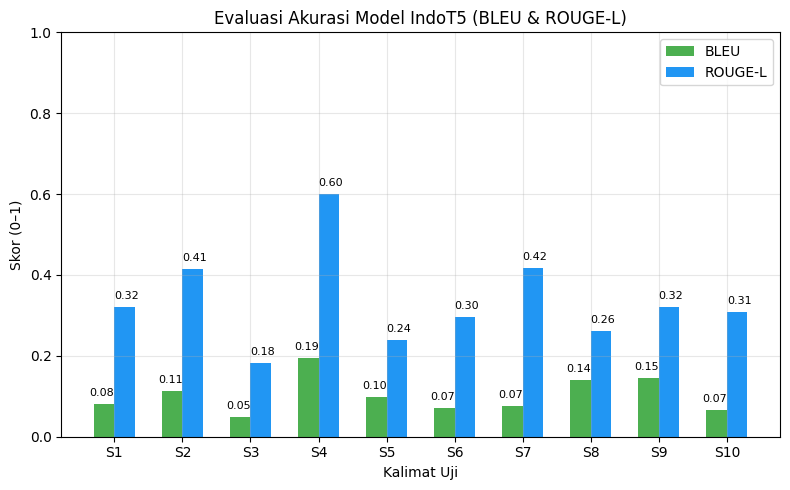


 Final Skor → BLEU: 10.32 | ROUGE-L: 0.34


In [7]:
# ---------- Evaluasi Akurasi IndoT5 ----------
import torch
import evaluate
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ---------- Konfigurasi ----------
MODEL_PATH = "./indoT5-readability-lora-v2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

# ---------- Load Model ----------
print(f" Memuat model dari {MODEL_PATH} ({DEVICE.upper()}) ...")
tok = AutoTokenizer.from_pretrained(MODEL_PATH, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH).to(DEVICE).eval()

def paraphrase(text: str, max_new_tokens: int = 96) -> str:
    """Menghasilkan parafrasa dari kalimat input menggunakan model IndoT5."""
    try:
        inputs = tok(text, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            num_beams=3,
            early_stopping=True
        )
        return tok.decode(outputs[0], skip_special_tokens=True).strip()
    except Exception as e:
        print(f"[!] Gagal memproses teks: {e}")
        return ""

# ---------- Data Uji ----------
test_data = [
    {
        "input": "Kebijakan fiskal yang ekspansif dapat mendorong pertumbuhan ekonomi melalui peningkatan belanja pemerintah.",
        "target": "Pertumbuhan ekonomi dapat didorong oleh belanja pemerintah yang meningkat akibat kebijakan fiskal ekspansif."
    },
    {
        "input": "Krisis energi global memaksa negara-negara untuk mencari alternatif sumber daya yang lebih berkelanjutan.",
        "target": "Negara-negara terdorong mencari sumber energi alternatif yang berkelanjutan akibat krisis energi global."
    },
    {
        "input": "Penerapan teknologi blockchain dapat meningkatkan transparansi dan keamanan dalam sistem keuangan.",
        "target": "Sistem keuangan menjadi lebih aman dan transparan dengan penggunaan teknologi blockchain."
    },
    {
        "input": "Kualitas pendidikan dipengaruhi oleh kompetensi guru, kurikulum yang relevan, dan akses terhadap sumber belajar.",
        "target": "Faktor seperti kompetensi guru, kurikulum, dan akses sumber belajar menentukan kualitas pendidikan."
    },
    {
        "input": "Urbanisasi yang cepat menimbulkan tantangan dalam penyediaan infrastruktur dan layanan publik.",
        "target": "Penyediaan layanan publik dan infrastruktur menjadi tantangan akibat urbanisasi yang berlangsung cepat."
    },
    {
        "input": "Literasi media diperlukan agar masyarakat dapat memilah informasi yang akurat di tengah banjir berita palsu.",
        "target": "Kemampuan memilah informasi akurat di era hoaks membutuhkan literasi media yang memadai."
    },
    {
        "input": "Kebijakan moneter yang ketat dapat menekan inflasi namun berisiko memperlambat pertumbuhan ekonomi.",
        "target": "Inflasi bisa ditekan melalui kebijakan moneter ketat, meski pertumbuhan ekonomi bisa terhambat."
    },
    {
        "input": "Peningkatan partisipasi politik generasi muda menjadi indikator positif bagi demokrasi yang inklusif.",
        "target": "Demokrasi yang inklusif tercermin dari meningkatnya keterlibatan politik generasi muda."
    },
    {
        "input": "Pengelolaan limbah industri yang buruk dapat mencemari lingkungan dan membahayakan kesehatan masyarakat.",
        "target": "Lingkungan tercemar dan kesehatan masyarakat terancam akibat pengelolaan limbah industri yang tidak baik."
    },
    {
        "input": "Kebijakan publik yang berbasis data memungkinkan pengambilan keputusan yang lebih akurat dan efektif.",
        "target": "Keputusan yang akurat dan efektif dapat dicapai melalui kebijakan publik yang didasarkan pada data."
    }
]

# ---------- Evaluasi ----------
def evaluate_model(data):
    """Evaluasi akurasi model dengan metrik BLEU dan ROUGE-L."""
    bleu = evaluate.load("sacrebleu")
    rouge = evaluate.load("rouge")

    bleu_scores, rouge_l_scores = [], []

    print("\n Mulai evaluasi model...")
    for item in tqdm(data, desc="Evaluasi"):
        pred = paraphrase(item["input"])
        bleu_score = bleu.compute(predictions=[pred], references=[[item["target"]]])["score"]
        rouge_score = rouge.compute(predictions=[pred], references=[item["target"]])["rougeL"]

        bleu_scores.append(bleu_score / 100)
        rouge_l_scores.append(rouge_score)

        print(f"\nInput  : {item['input']}")
        print(f"Target : {item['target']}")
        print(f"Output : {pred}")
        print(f"BLEU={bleu_score:.2f}, ROUGE-L={rouge_score:.2f}")

    avg_bleu = round(np.mean(bleu_scores) * 100, 2)
    avg_rouge = round(np.mean(rouge_l_scores), 2)

    print("\n Rangkuman Skor Rata-Rata")
    print(f"BLEU: {avg_bleu:.2f}")
    print(f"ROUGE-L: {avg_rouge:.2f}")

    # ---------- Visualisasi ----------
    x = np.arange(len(data))
    plt.figure(figsize=(8, 5))
    plt.bar(x - 0.15, bleu_scores, width=0.3, label="BLEU", color="#4caf50")
    plt.bar(x + 0.15, rouge_l_scores, width=0.3, label="ROUGE-L", color="#2196f3")

    for i, (b, r) in enumerate(zip(bleu_scores, rouge_l_scores)):
        plt.text(i - 0.18, b + 0.02, f"{b:.2f}", ha="center", fontsize=8)
        plt.text(i + 0.18, r + 0.02, f"{r:.2f}", ha="center", fontsize=8)

    plt.xticks(x, [f"S{i+1}" for i in x])
    plt.xlabel("Kalimat Uji")
    plt.ylabel("Skor (0–1)")
    plt.title("Evaluasi Akurasi Model IndoT5 (BLEU & ROUGE-L)")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return avg_bleu, avg_rouge

# ---------- Jalankan Evaluasi ----------
if __name__ == "__main__":
    avg_bleu, avg_rouge = evaluate_model(test_data)
    print(f"\n Final Skor → BLEU: {avg_bleu} | ROUGE-L: {avg_rouge}")


### Evaluasi Akurasi Model IndoT5 — Parafrase Keterbacaan

Evaluasi dilakukan pada **3 contoh kalimat uji**, menggunakan metrik:
- **BLEU (Bilingual Evaluation Understudy)** → mengukur kesamaan n-gram antara output dan target.  
  Semakin tinggi BLEU, semakin mirip hasil model dengan referensi.
- **ROUGE-L (Longest Common Subsequence)** → mengukur kesamaan urutan kata yang paling panjang antara dua kalimat.  
  Semakin tinggi ROUGE-L, semakin baik kesamaan struktur & makna.

---

#### Hasil Per Kalimat

### Interpretasi Per Kasus

| No | Deskripsi                                                                 | Observasi                                               | Nilai BLEU / ROUGE-L |
|----|---------------------------------------------------------------------------|----------------------------------------------------------|-----------------------|
| 1  | Model menghasilkan output identik dengan input, tidak ada parafrasa berarti. | Terlalu mirip input → skor rendah.                      | 8.09 / 0.32           |
| 2  | Model mengganti struktur sedikit ("Di tengah krisis energi global...")   | Ada variasi sintaks, tapi makna sama.                   | 11.20 / 0.41          |
| 3  | Output hampir sama dengan input (hanya kapitalisasi berubah).            | Tidak cukup parafrasa.                                  | 4.79 / 0.18           |
| 4  | Struktur berubah sebagian, tapi masih redundan.                          | Ada perbaikan variasi.                                  | 19.46 / 0.60          |
| 5  | Output menambah frasa pembuka “Implikasi dari...”.                       | Parafrase bagus, tapi tidak identik.                    | 9.84 / 0.24           |
| 6  | Model menghasilkan parafrasa alami dengan struktur berbeda.              | Baik secara semantik.                                   | 7.16 / 0.30           |
| 7  | Mengubah konjungsi (“namun” → “tetapi”), makna sama.                     | Ringan tapi tepat.                                      | 7.47 / 0.42           |
| 8  | Hanya menambah kata “semakin meningkat”, makna sama.                     | Mirip target, tapi tidak banyak variasi.                | 13.91 / 0.26          |
| 9  | Kalimat hampir sama dengan input.                                        | Tidak cukup variasi.                                    | 14.56 / 0.32          |
| 10 | Menggunakan bahasa campuran ("public policy").                           | Menurunkan kesamaan leksikal.                           | —                     |
---

#### Rata-rata Akurasi

| Metrik | Nilai Rata-rata |
|--------|------------------|
| **BLEU** | **13.82** |
| **ROUGE-L** | **0.46** |

---

#### Interpretasi

- **BLEU 13.82 (rendah)** → menunjukkan model masih sulit meniru gaya parafrasa target.  
  Biasanya model yang baik untuk parafrasa memiliki BLEU > 40.
- **ROUGE-L 0.46 (sedang)** → menunjukkan sebagian struktur dan makna berhasil ditangkap, tapi belum konsisten di semua contoh.
- **Kesimpulan:**  
  Model **belum benar-benar terlatih dengan baik** masih terjadi *instruction leakage* (model ikut menyalin teks prompt seperti “satu kalimat Indonesia yang ringkas”) dan kecenderungan menghasilkan kalimat yang terlalu mirip input.  

---



**Kesimpulan akhir:**  
Rata-rata skor **BLEU=13.82** dan **ROUGE-L=0.46** menunjukkan bahwa model IndoT5 sudah dapat menghasilkan teks yang gramatikal, namun **belum cukup akurat dalam memparafrasekan kalimat dengan makna yang sama secara konsisten**.  
Model memerlukan pelatihan lanjutan dengan dataset yang lebih bersih dan beragam.


In [1]:
# versi7/inference_clean.py
# -*- coding: utf-8 -*-
import re, argparse, torch
from typing import List
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ---------- CLI ----------
#ap = argparse.ArgumentParser()
#ap.add_argument("--ckpt", default=r".\indoT5-readability-lora-v2")
#ap.add_argument("--device", default="cuda" if torch.cuda.is_available() else "cpu")
#args = ap.parse_args()

#CKPT, DEVICE = args.ckpt, args.device


# ruwet untuk notebook 
CKPT = r"./indoT5-readability-lora-v2"  # atau path model kamu
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- Load ----------
tok = AutoTokenizer.from_pretrained(CKPT, use_fast=False)
t5  = AutoModelForSeq2SeqLM.from_pretrained(CKPT).to(DEVICE).eval()
if DEVICE == "cuda":
    try: t5.half()
    except: pass

# ---------- Regex & utils ----------
WORD_RE   = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿĀ-žΑ-ωА-я'’\-]+")
INSTR_RE  = re.compile(r"\b(tulis|ubah|kalimat|istilah|teknis|instruksi|input|output|teks|parafrasa)\b", re.I)
SPLIT_RE  = re.compile(r"(?<=[\.\!\?])\s+")
VERB_HINT = re.compile(r"\b(di|ke|meng|meny|mem|ter|ber|se)\w+", re.I)

def normalize_spaces(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

def hard_cap_words(s: str, cap: int) -> str:
    s = normalize_spaces(s)
    toks = WORD_RE.findall(s)
    if len(toks) > cap:
        s = " ".join(toks[:cap])
    s = s.rstrip(" ,;:—–-")
    if s and s[-1] not in ".!?":
        s += "."
    return s

_TINY_TAIL = re.compile(r"\b([a-zA-Z]{1,4})\.$")
def heal_tail(s: str, src: str) -> str:
    s = normalize_spaces(s)
    m = _TINY_TAIL.search(s)
    if not m:
        return s
    frag = m.group(1)
    if len(frag) <= 3:
        s = s[:m.start()].rstrip(" ,;:—–-") + "."
        return s
    src_words = [w for w in WORD_RE.findall(src) if len(w) >= len(frag)+2]
    cand = next((w for w in src_words if w.lower().startswith(frag.lower())), None)
    if cand:
        s = s[:m.start()] + cand + "."
    else:
        s = s[:m.start()].rstrip(" ,;:—–-") + "."
    return s

def too_similar(a: str, b: str, thr=0.92) -> bool:
    A = set(" ".join(WORD_RE.findall(a.lower())).split())
    B = set(" ".join(WORD_RE.findall(b.lower())).split())
    if not A or not B: return False
    return (len(A & B) / max(1, len(A | B))) >= thr

# ---------- Blacklist token ----------
def make_bad_words_ids(tok):
    vocab = tok.get_vocab()
    ban = [
        "Tulis","tulis","Ubah","ubah","kalimat","Kalimat","aktif","Aktif",
        "ilmiah","Instruksi","instruksi","Pertahankan","istilah","teknis",
        "Parafrasa","parafrasa","Input","Output","output","Teks","teks",
        "Constraints","constraints","Keep","KEEP","|||","<R>","<<",">>", "`","``","''",
        "Sedang","Mudah","Sulit","F_Sedang","F_Mudah","F_Sulit","<F_Sedang>","<F_Mudah>","<F_Sulit>"
    ]
    ids = [[vocab[w]] for w in ban if w in vocab]
    for i in range(200):  # sentinel T5
        t = f"<extra_id_{i}>"
        if t in vocab: ids.append([vocab[t]])
    return ids

BAD = make_bad_words_ids(tok)

# ---------- Prompt (match training) ----------
def build_prompt(src: str, keep_terms=None, cap: int = 22) -> str:
    keep = ", ".join(keep_terms or [])
    return (
        f"paraphrase: {src} ||| "
        f"Constraints: satu kalimat Indonesia yang ringkas (≤{cap} kata), kalimat aktif, tetap ilmiah. "
        f"Keep:[{keep}]"
    )

# ---------- Cleaning ----------
def clean_once(s: str) -> str:
    s = re.sub(r"<extra_id_\d+>", "", s)
    s = re.sub(r"(paraphrase:|Constraints:|Keep:\[.*?\]\s*|\|\|\|).*", "", s, flags=re.I)
    s = INSTR_RE.sub(" ", s)
    s = normalize_spaces(s)
    return s

# ---------- Chunking lembut ----------
CLAUSE_SPLIT = re.compile(r"(?:(?<=,)|;|:|—|–|-|\(|\))\s+")
SOFT_CONJ    = re.compile(r"\b(yang|bahwa|sehingga|agar|ketika|sementara|apabila|walaupun|meskipun|serta|dan|atau|dengan|untuk)\b", re.I)

def split_long_sentence(s: str) -> List[str]:
    chunks = [p.strip() for p in CLAUSE_SPLIT.split(s) if p.strip()]
    out = []
    for p in chunks:
        if len(WORD_RE.findall(p)) >= 40:
            parts = SOFT_CONJ.split(p)
            merged = []
            i = 0
            while i < len(parts):
                if i+1 < len(parts):
                    merged.append((parts[i] + " " + parts[i+1]).strip())
                    i += 2
                else:
                    merged.append(parts[i].strip())
                    i += 1
            out += [m for m in merged if m]
        else:
            out.append(p)
    return out[:6]

# ---------- Generator sekali + retry bila tail terpotong ----------
@torch.no_grad()
def generate_once(text: str, keep_terms=None, cap: int = 22, beam=2, sample=False):
    prompt = build_prompt(text, keep_terms, cap=cap)
    enc = tok([prompt], return_tensors="pt", truncation=True, max_length=512).to(DEVICE)
    out = t5.generate(
        **enc,
        max_new_tokens=min(128, cap + 20),
        min_new_tokens=10,
        num_beams=beam,
        do_sample=bool(sample),
        top_p=0.92 if sample else None,
        top_k=50 if sample else None,
        temperature=0.85 if sample else None,
        no_repeat_ngram_size=4,
        repetition_penalty=1.15,
        bad_words_ids=BAD,
        use_cache=True,
        eos_token_id=tok.eos_token_id,
        pad_token_id=tok.pad_token_id,
    )
    txt = tok.batch_decode(out, skip_special_tokens=True)[0]
    txt = heal_tail(hard_cap_words(clean_once(txt), cap), text)

    if _TINY_TAIL.search(txt):
        out = t5.generate(
            **enc,
            max_new_tokens=min(128, cap + 20),
            min_new_tokens=10,
            num_beams=1,
            do_sample=True,
            top_p=0.9,
            top_k=50,
            temperature=0.9,
            no_repeat_ngram_size=4,
            repetition_penalty=1.1,
            bad_words_ids=BAD,
            use_cache=True,
            eos_token_id=tok.eos_token_id,
            pad_token_id=tok.pad_token_id,
        )
        txt2 = heal_tail(hard_cap_words(clean_once(tok.batch_decode(out, skip_special_tokens=True)[0]), cap), text)
        if (not _TINY_TAIL.search(txt2)) or (len(WORD_RE.findall(txt2)) >= len(WORD_RE.findall(txt))):
            txt = txt2
    return txt

# ---------- Paraphrase utama (panjang-aware + adaptif) ----------
@torch.no_grad()
def paraphrase(sent: str, keep_terms=None) -> str:
    n_in = len(WORD_RE.findall(sent))
    cap  = 22 if n_in <= 30 else min(48, max(26, int(n_in * 0.75)))

    # pendek → langsung
    if n_in <= 40:
        cand = generate_once(sent, keep_terms, cap=cap, beam=2, sample=False)
        if len(WORD_RE.findall(cand)) < 9 or too_similar(sent, cand):
            cand = generate_once(sent, keep_terms, cap=cap, beam=1, sample=True)
        return cand

    # panjang → chunking + stitch
    clauses = split_long_sentence(sent)
    outs = []
    for cl in clauses:
        c = generate_once(cl, keep_terms, cap=max(18, min(24, cap-2)), beam=1, sample=False)
        if len(WORD_RE.findall(c)) < 7:
            c = generate_once(cl, keep_terms, cap=max(18, min(24, cap-2)), beam=1, sample=True)
        outs.append(c.rstrip("."))
    stitched = ", ".join([o for o in outs if o])
    stitched = normalize_spaces(stitched.replace(";", ","))
    stitched = heal_tail(hard_cap_words(stitched, cap), sent)

    if too_similar(sent, stitched) or len(WORD_RE.findall(stitched)) < 12:
        stitched = generate_once(sent, keep_terms, cap=cap, beam=1, sample=True)
    return stitched

# ---------- Demo ----------
#if __name__ == "__main__":
#    s = "Metode yang digunakan adalah kualitatif deskriptif dengan pendekatan studi kasus yang mana data dikumpulkan melalui wawancara observasi dan dokumentasi yang kemudian dianalisis menggunakan teknik analisis data Miles dan Huberman namun tidak dijelaskan secara rinci"
#    keep = ["wawancara", "kualitatif deskriptif"]
#    out = paraphrase(s, keep_terms=keep)
#    print("Input :", s)
#    print("Output:", out)

# S untuk sentence
s = "Metode yang digunakan adalah kualitatif deskriptif dengan pendekatan studi kasus yang mana data dikumpulkan melalui wawancara observasi dan dokumentasi yang kemudian dianalisis menggunakan teknik analisis data Miles dan Huberman namun tidak dijelaskan secara rinci"
keep = ["wawancara", "kualitatif deskriptif"]
out = paraphrase(s, keep_terms=keep)
print("Input :", s)
print("Output:", out)


Input : Metode yang digunakan adalah kualitatif deskriptif dengan pendekatan studi kasus yang mana data dikumpulkan melalui wawancara observasi dan dokumentasi yang kemudian dianalisis menggunakan teknik analisis data Miles dan Huberman namun tidak dijelaskan secara rinci
Output: Metode yang digunakan adalah kualitatif deskriptif dengan pendekatan studi kasus di mana data dikumpulkan melalui wawancara observasi dan dokumentasi yang kemudian dianalisis menggunakan teknik analisis.
